In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cpu


In [ ]:
import torch

# torch.autograd.set_detect_anomaly(True)


def MSE(y, y_pred):
    return 0.5 * (y - y_pred) ** 2


class PredictiveLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.x = None

    def forward(self, mu: torch.Tensor):
        if self.training:
            if self.x is None:
                x_data = mu.detach().clone()
                x = torch.nn.Parameter(x_data.to(mu.device), True)
                self.x = x

            energy = MSE(mu, self.x)
            self.energy = energy.sum()
            return self.x
        else:
            return mu


class PredictiveTrainer:
    def __init__(
        self,
        T: int,
        model: torch.nn.Module,
        optimizer_x_fn,
        optimizer_p_fn,
        x_lr,
        p_lr,
    ):
        self.T = T
        self.model = model
        self.optimizer_x_fn = optimizer_x_fn
        self.optimizer_p_fn = optimizer_p_fn
        self.x_lr = x_lr
        self.p_lr = p_lr

        self.optimizer_p = None
        self.optimizer_x = None

    def get_pc_layers(self):
        for module in self.model.modules():
            if isinstance(module, PredictiveLayer):
                yield module

    def get_internal_representations(self):
        for pc_layer in self.get_pc_layers():
            model_x = pc_layer.x
            if model_x is not None:
                yield model_x

    def get_weights(self):
        internal_reps = self.get_internal_representations()
        for param in self.model.parameters():
            if not any(param is x for x in internal_reps):
                yield param

    def create_optimizer_x(self):
        self.optimizer_x: torch.optim.Optimizer = self.optimizer_x_fn(
            self.get_internal_representations(), lr=self.x_lr
        )

    def create_optimizer_p(self):
        self.optimizer_p: torch.optim.Optimizer = self.optimizer_p_fn(
            self.get_weights(), lr=self.p_lr
        )

    def train_batch(self, inputs, label, loss_fn):
        results = {
            "loss": [],
            "energy": [],
            "combined": [],
        }

        for t in range(self.T):

            if t == 0:
                for pc_layer in self.get_pc_layers():
                    pc_layer.x = None
                    # setting it to None initialises x with mu
            outputs = self.model(inputs).clone()

            if t == 0:
                self.create_optimizer_x()
                if self.optimizer_p is None:
                    self.create_optimizer_p()

            loss = loss_fn(outputs, label)
            energy = sum([pc_layer.energy for pc_layer in self.get_pc_layers()])

            combined = sum([loss, energy])

            if t == self.T - 1:
                self.optimizer_p.zero_grad()
            self.optimizer_x.zero_grad()

            combined.backward()

            self.optimizer_x.step()
            if t == self.T - 1:
                self.optimizer_p.step()

            results["loss"].append(loss.item())
            results["energy"].append(energy.item())
            results["combined"].append(combined.item())

        return results


In [ ]:
input_size = 28*28  # 28x28 images
hidden_size = 256
output_size = 10    # 10 classes
activation_fn = torch.nn.ReLU
loss_fn = lambda output, _target: 0.5 * (output - _target).pow(2).sum() # this loss function holds to the error of the output layer of the model


pc_model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    PredictiveLayer(),
    activation_fn(),
    nn.Linear(hidden_size, hidden_size),
    PredictiveLayer(),
    activation_fn(),
    nn.Linear(hidden_size, output_size)
)
pc_model.train()   # set the model to training mode
pc_model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): PredictiveLayer()
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): PredictiveLayer()
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# number of inference iterations where the latent states x are updated. Inference does not run till convergence but for a fixed number of iterations
T = 20

# options for the update of the latent state x
optimizer_x_fn = optim.SGD          # optimizer for latent state x, SGD perform gradient descent. Other alternative are Adam, RMSprop, etc.

# options for the update of the parameters p
optimizer_p_fn = optim.Adam         # optimizer for parameters p

trainer = PredictiveTrainer(model=pc_model,
    T = T,
    optimizer_x_fn = optimizer_x_fn,
    optimizer_p_fn = optimizer_p_fn,
    x_lr = 0.01,
    p_lr = 0.001,
)

In [ ]:
# get classification accuracy of the model
def test(model, X, y):
    model.eval()
    correct = 0
    total = 0
    pred = model(X)
    loss = 0.5 * torch.mean(torch.sum((y - pred) ** 2, axis=1))
    # _, predicted = torch.max(pred, -1)
    # total += y.size(0)
    # correct += (predicted == y).sum().item()
    model.train()
    return {'accuracy': 0, 'y_pred': 0, 'y': 0, 'loss': loss}
    # return {'accuracy': round(correct / total, 4), 'y_pred': predicted, 'y': y, 'loss': loss}

Loading MNIST data...
Starting training...
Epoch 1/10, Batch 0, Loss: 2.3002
Epoch 1/10, Batch 0, Loss: 0.4148
Epoch 1/10, Batch 10, Loss: 2.2979
Epoch 1/10, Batch 10, Loss: 0.3093
Epoch 1/10, Batch 20, Loss: 2.3037
Epoch 1/10, Batch 20, Loss: 0.2327
Epoch 1/10, Batch 30, Loss: 2.3015
Epoch 1/10, Batch 30, Loss: 0.2155
Epoch 1/10, Batch 40, Loss: 2.2977
Epoch 1/10, Batch 40, Loss: 0.2191
Epoch 1/10, Batch 50, Loss: 2.2962
Epoch 1/10, Batch 50, Loss: 0.1469
Epoch 1/10, Batch 60, Loss: 2.2972
Epoch 1/10, Batch 60, Loss: 0.1550
Epoch 1/10, Batch 70, Loss: 2.2996
Epoch 1/10, Batch 70, Loss: 0.1126
Epoch 1/10, Batch 80, Loss: 2.2948
Epoch 1/10, Batch 80, Loss: 0.1077
Epoch 1/10, Batch 90, Loss: 2.2974
Epoch 1/10, Batch 90, Loss: 0.1473
Epoch 1/10, Batch 100, Loss: 2.2960
Epoch 1/10, Batch 100, Loss: 0.1098
Epoch 1/10, Batch 110, Loss: 2.2975
Epoch 1/10, Batch 110, Loss: 0.1113
Epoch 1/10, Batch 120, Loss: 2.2966
Epoch 1/10, Batch 120, Loss: 0.1510
Epoch 1/10, Batch 130, Loss: 2.2942
Epoch 1

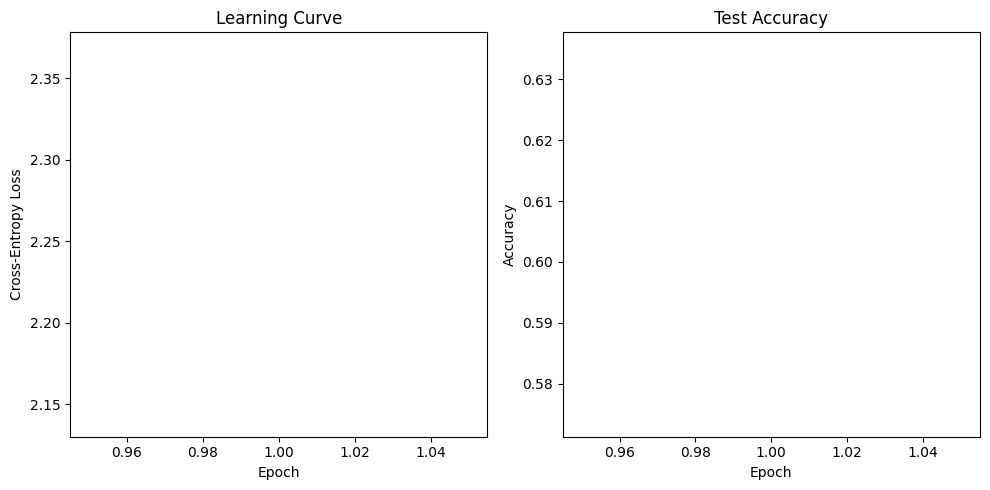

Epoch 2/10, Batch 0, Loss: 2.1923
Epoch 2/10, Batch 0, Loss: 0.0134
Epoch 2/10, Batch 10, Loss: 2.2016
Epoch 2/10, Batch 10, Loss: 0.0123
Epoch 2/10, Batch 20, Loss: 2.1983
Epoch 2/10, Batch 20, Loss: 0.0167
Epoch 2/10, Batch 30, Loss: 2.1835
Epoch 2/10, Batch 30, Loss: 0.0176
Epoch 2/10, Batch 40, Loss: 2.2045
Epoch 2/10, Batch 40, Loss: 0.0294
Epoch 2/10, Batch 50, Loss: 2.1918
Epoch 2/10, Batch 50, Loss: 0.0322
Epoch 2/10, Batch 60, Loss: 2.1899
Epoch 2/10, Batch 60, Loss: 0.0358
Epoch 2/10, Batch 70, Loss: 2.1686
Epoch 2/10, Batch 70, Loss: 0.0164
Epoch 2/10, Batch 80, Loss: 2.1842
Epoch 2/10, Batch 80, Loss: 0.0343
Epoch 2/10, Batch 90, Loss: 2.1716
Epoch 2/10, Batch 90, Loss: 0.0477
Epoch 2/10, Batch 100, Loss: 2.1993
Epoch 2/10, Batch 100, Loss: 0.0414
Epoch 2/10, Batch 110, Loss: 2.1478
Epoch 2/10, Batch 110, Loss: 0.0486
Epoch 2/10, Batch 120, Loss: 2.1809
Epoch 2/10, Batch 120, Loss: 0.0513
Epoch 2/10, Batch 130, Loss: 2.1378
Epoch 2/10, Batch 130, Loss: 0.0187
Epoch 2/10, Ba

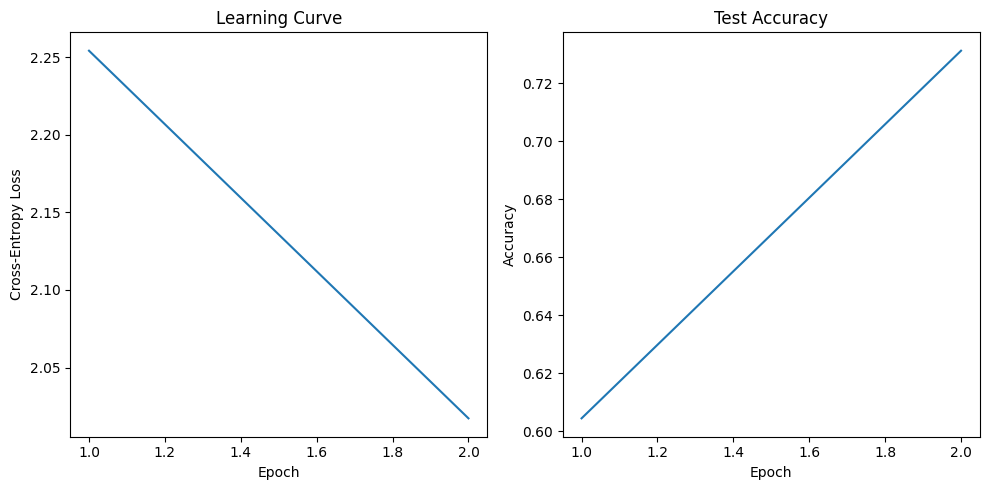

Epoch 3/10, Batch 0, Loss: 1.8103
Epoch 3/10, Batch 0, Loss: 0.0116
Epoch 3/10, Batch 10, Loss: 1.8496
Epoch 3/10, Batch 10, Loss: 0.0070
Epoch 3/10, Batch 20, Loss: 1.8069
Epoch 3/10, Batch 20, Loss: 0.0068
Epoch 3/10, Batch 30, Loss: 1.7810
Epoch 3/10, Batch 30, Loss: 0.0108
Epoch 3/10, Batch 40, Loss: 1.8421
Epoch 3/10, Batch 40, Loss: 0.0131
Epoch 3/10, Batch 50, Loss: 1.7868
Epoch 3/10, Batch 50, Loss: 0.0185
Epoch 3/10, Batch 60, Loss: 1.7442
Epoch 3/10, Batch 60, Loss: 0.0186
Epoch 3/10, Batch 70, Loss: 1.7138
Epoch 3/10, Batch 70, Loss: 0.0100
Epoch 3/10, Batch 80, Loss: 1.7518
Epoch 3/10, Batch 80, Loss: 0.0313
Epoch 3/10, Batch 90, Loss: 1.7509
Epoch 3/10, Batch 90, Loss: 0.0297
Epoch 3/10, Batch 100, Loss: 1.7951
Epoch 3/10, Batch 100, Loss: 0.0312
Epoch 3/10, Batch 110, Loss: 1.6527
Epoch 3/10, Batch 110, Loss: 0.0497
Epoch 3/10, Batch 120, Loss: 1.7716
Epoch 3/10, Batch 120, Loss: 0.0251
Epoch 3/10, Batch 130, Loss: 1.6375
Epoch 3/10, Batch 130, Loss: 0.0067
Epoch 3/10, Ba

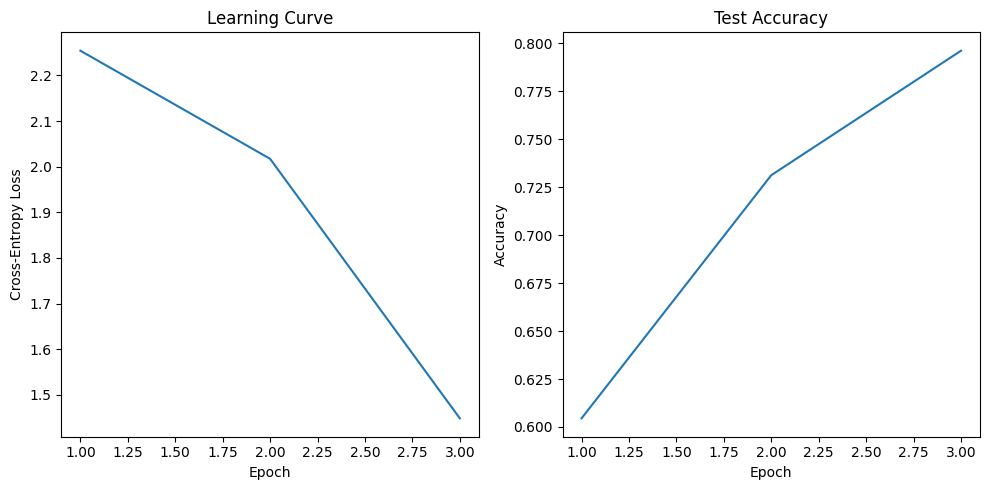

Epoch 4/10, Batch 0, Loss: 1.1584
Epoch 4/10, Batch 0, Loss: 0.0076
Epoch 4/10, Batch 10, Loss: 1.2165
Epoch 4/10, Batch 10, Loss: 0.0066
Epoch 4/10, Batch 20, Loss: 1.2231
Epoch 4/10, Batch 20, Loss: 0.0045
Epoch 4/10, Batch 30, Loss: 1.2203
Epoch 4/10, Batch 30, Loss: 0.0047
Epoch 4/10, Batch 40, Loss: 1.3180
Epoch 4/10, Batch 40, Loss: 0.0104
Epoch 4/10, Batch 50, Loss: 1.1593
Epoch 4/10, Batch 50, Loss: 0.0151
Epoch 4/10, Batch 60, Loss: 1.0780
Epoch 4/10, Batch 60, Loss: 0.0154
Epoch 4/10, Batch 70, Loss: 1.0862
Epoch 4/10, Batch 70, Loss: 0.0076
Epoch 4/10, Batch 80, Loss: 1.0915
Epoch 4/10, Batch 80, Loss: 0.0292
Epoch 4/10, Batch 90, Loss: 1.1738
Epoch 4/10, Batch 90, Loss: 0.0260
Epoch 4/10, Batch 100, Loss: 1.1930
Epoch 4/10, Batch 100, Loss: 0.0276
Epoch 4/10, Batch 110, Loss: 1.1074
Epoch 4/10, Batch 110, Loss: 0.0467
Epoch 4/10, Batch 120, Loss: 1.2703
Epoch 4/10, Batch 120, Loss: 0.0193
Epoch 4/10, Batch 130, Loss: 0.9740
Epoch 4/10, Batch 130, Loss: 0.0052
Epoch 4/10, Ba

KeyboardInterrupt: 

In [ ]:
#WeightPerturb V2:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

class WeightPerturbMLP:
    def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
        self.W_h = np.random.normal(0, sigma, (input_size, hidden_size))
        self.W_y = np.random.normal(0, sigma, (hidden_size, output_size))
        self.sigma = sigma

    def forward(self, X):
        self.h = np.maximum(0, X @ self.W_h)  # ReLU activation
        self.y = self.h @ self.W_y
        return self.y

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def loss(self, X, targets):
        outputs = self.softmax(self.forward(X))
        return -np.mean(np.sum(targets * np.log(outputs + 1e-10), axis=1))

    def weight_perturbation(self, X, targets, eta, K):
        base_loss = self.loss(X, targets)

        W_h_update = np.zeros_like(self.W_h)
        W_y_update = np.zeros_like(self.W_y)

        for _ in range(K):
            Psi_h = np.random.normal(0, self.sigma, self.W_h.shape)
            Psi_y = np.random.normal(0, self.sigma, self.W_y.shape)

            W_h_perturbed = self.W_h + Psi_h
            W_y_perturbed = self.W_y + Psi_y

            self.W_h, self.W_y = W_h_perturbed, W_y_perturbed
            perturbed_loss = self.loss(X, targets)
            self.W_h, self.W_y = W_h_perturbed - Psi_h, W_y_perturbed - Psi_y

            delta_loss = perturbed_loss - base_loss

            W_h_update += (delta_loss * Psi_h) / (self.sigma**2)
            W_y_update += (delta_loss * Psi_y) / (self.sigma**2)

        W_h_update *= -eta / K
        W_y_update *= -eta / K

        return W_h_update, W_y_update

# Load and preprocess MNIST data
print("Loading MNIST data...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Initialize model
model = WeightPerturbMLP(784, 500, 10, sigma=0.01)

# Training parameters
epochs = 10
batch_size = 32
eta = 0.001  # Reduced learning rate
K = 10  # number of perturbation samples

# Training loop
losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(epochs):
    epoch_losses = []
    pc_epoch_losses = []
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train_onehot[i:i+batch_size]

        W_h_update, W_y_update = model.weight_perturbation(batch_X, batch_y, eta, K)

        model.W_h += W_h_update
        model.W_y += W_y_update

        batch_loss = model.loss(batch_X, batch_y)
        epoch_losses.append(batch_loss)

        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {batch_loss:.4f}")

        batch_X = torch.from_numpy(batch_X).float()
        batch_y = torch.from_numpy(batch_y).float()

        trainer.train_batch(
                inputs=batch_X,
                loss_fn=loss_fn,
                label=batch_y
            )

        results = test(pc_model, batch_X, batch_y)
        pc_batch_loss = results['loss']
        pc_epoch_losses.append(pc_batch_loss)

        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {pc_batch_loss:.4f}")


    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)

    # Evaluate on test set
    y_pred = model.softmax(model.forward(X_test))
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Plot learning curve after each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

print("Training completed. Generating final visualizations...")

# Final Confusion Matrix
y_pred = model.softmax(model.forward(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("All done!")

Feedback Alignment:



$\newcommand{\stim}{\mathbf{x}}$
$\newcommand{\h}{\mathbf{h}}$
$\newcommand{\noisew}{\boldsymbol \Psi}$
$\newcommand{\noiser}{\boldsymbol \xi}$
$\newcommand{\target}{y}$
$\newcommand{\pred}{\mathbf{\hat{y}}}$
$\newcommand{\identity}{\mathbf{I}}$
$\newcommand{\blackbox}{f}$
$\newcommand{\weight}{\mathbf{W}}$
$\newcommand{\weightout}{\mathbf{W}^{\textrm{out}}}$
$\newcommand{\loss}{\mathcal{L}}$
$\newcommand{\derivative}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\rate}{\mathbf{r}}$
$\newcommand{\error}{\boldsymbol \delta}$
$\newcommand{\losserror}{\mathbf{e}}$
$\newcommand{\backweight}{\mathbf{B}}$

In this section, we describe the __Feedback Alignment__ algorithm. Unlike weight and node perturbation, feedback alignment provides a mechanism whereby individual neurons can receive *targeted* error signals. To start, we assume the following network setup:

\begin{align}
    \pred = \blackbox(\weight \stim) = \weightout\sigma(\weight\stim) =\weightout \h
\end{align}

With a mean squared error loss over all of the output neurons.
\begin{equation}
    \loss = \frac{1}{2n} \sum_{k=1}^{n}\left (\target_k - \hat{y}_k \right )^2
\end{equation}

Note here we have suppressed the batch index notation, and will calculate the following gradients as averages over batch elements.

Backpropagation updates parameters using the gradient of the loss scaled by the learning rate $\eta$.

\begin{align}
    \Delta \weight_{ji} &= - \eta \derivative{\loss}{\weight}_{ji} \\
    &= - \eta \underbrace{\derivative{\loss}{\pred}\derivative{\pred}{h_j}}_{\delta_j}\derivative{h_j}{\weight_{ji}}\\
    &= - \eta \delta_j \sigma^{\prime}(\weight\stim)_j\stim_i \\
    &= - \eta \delta_j h^{\prime}_j\stim_i
\end{align}

While $h^{\prime}_j$ and $\stim_i$ are available locally to the neuron, calculating $\delta_j$
involves non-local information, and is therefore biologically implausible.

\begin{align}
    \delta_j &= \derivative{\loss}{h_j} \\
    &= \sum_{k=1}^n \derivative{\loss}{\hat{y}_k}\derivative{\hat{y}_k}{h_j} \\
    &= \sum_{k=1}^n \overbrace{(y_k - \hat{y_k})}^{e_k} \weightout_{kj} \\
    &= e_1 {\color{red}\weightout_{1j}} + e_2 {\color{green}\weightout_{2j}} + e_3{\color{magenta}\weightout_{3j}}
\end{align}

In order to calculate $\delta_j$ we need to use all of of the outgoing weights from neuron $h_j$.

Writing $\error$ as a column vector (i.e. $\derivative{\loss}{\h}$ in  [denominator layout](https://en.wikipedia.org/wiki/Matrix_calculus#Layout_conventions)) we see that in order to calculate $\error$ we need the transpose of the forward weights.
\begin{align}
    \error &= \weight_{out}^T \losserror .
\end{align}

<img src="https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D3_Microlearning/static/feedback_alignment.png" width="400">

*From Lillicrap et al. (2016), CC-BY*

Feedback alignment replaces $\weight_{out}^T $ with a random matrix, $\backweight$. This resolves the 'weight transport' problem, because the feedback weights are no longer the same as the feedforward weights. However, by replacing $\weight_{out}^T$ with $\backweight$, we are no longer calculating an accurate gradient! Interestingly, we will see empirically in subsequent sections that this replacement still produces reasonably good gradient estimates, though it still introduces *bias*.

Loading MNIST data...
Starting training...
Epoch 1/10, Batch 0, Loss: 0.4788
Epoch 1/10, Batch 10, Loss: 0.4258
Epoch 1/10, Batch 20, Loss: 0.3800
Epoch 1/10, Batch 30, Loss: 0.3552
Epoch 1/10, Batch 40, Loss: 0.3145
Epoch 1/10, Batch 50, Loss: 0.2933
Epoch 1/10, Batch 60, Loss: 0.2878
Epoch 1/10, Batch 70, Loss: 0.2504
Epoch 1/10, Batch 80, Loss: 0.2614
Epoch 1/10, Batch 90, Loss: 0.2415
Epoch 1/10, Batch 100, Loss: 0.2333
Epoch 1/10, Batch 110, Loss: 0.2341
Epoch 1/10, Batch 120, Loss: 0.2479
Epoch 1/10, Batch 130, Loss: 0.2112
Epoch 1/10, Batch 140, Loss: 0.2025
Epoch 1/10, Batch 150, Loss: 0.1936
Epoch 1/10, Batch 160, Loss: 0.2125
Epoch 1/10, Batch 170, Loss: 0.2011
Epoch 1/10, Batch 180, Loss: 0.1831
Epoch 1/10, Batch 190, Loss: 0.2319
Epoch 1/10, Batch 200, Loss: 0.1711
Epoch 1/10, Batch 210, Loss: 0.1934
Epoch 1/10, Batch 220, Loss: 0.1869
Epoch 1/10, Batch 230, Loss: 0.1993
Epoch 1/10, Batch 240, Loss: 0.1805
Epoch 1/10, Batch 250, Loss: 0.1699
Epoch 1/10, Batch 260, Loss: 0.1

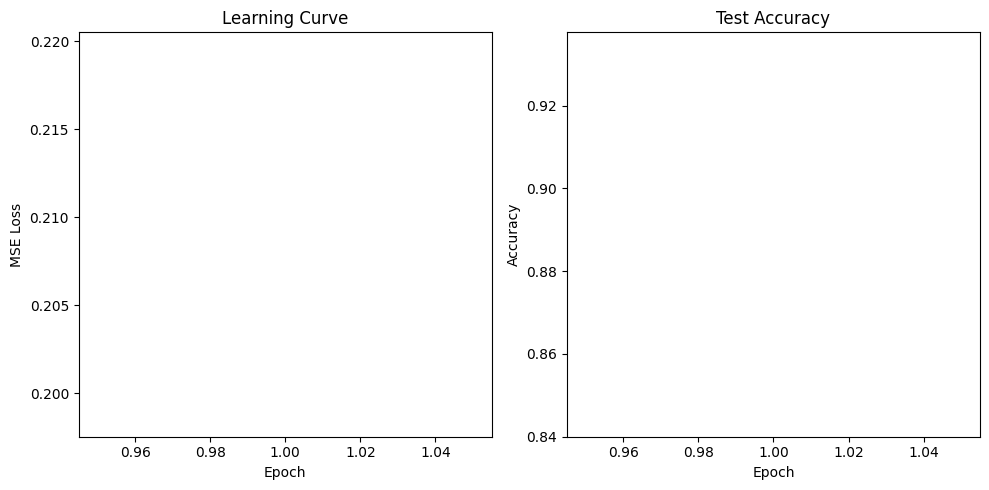

Epoch 2/10, Batch 0, Loss: 0.1367
Epoch 2/10, Batch 10, Loss: 0.1693
Epoch 2/10, Batch 20, Loss: 0.1386
Epoch 2/10, Batch 30, Loss: 0.1695
Epoch 2/10, Batch 40, Loss: 0.1439
Epoch 2/10, Batch 50, Loss: 0.1453
Epoch 2/10, Batch 60, Loss: 0.1488
Epoch 2/10, Batch 70, Loss: 0.1279
Epoch 2/10, Batch 80, Loss: 0.1369
Epoch 2/10, Batch 90, Loss: 0.1327
Epoch 2/10, Batch 100, Loss: 0.1260
Epoch 2/10, Batch 110, Loss: 0.1314
Epoch 2/10, Batch 120, Loss: 0.1577
Epoch 2/10, Batch 130, Loss: 0.1296
Epoch 2/10, Batch 140, Loss: 0.1111
Epoch 2/10, Batch 150, Loss: 0.1041
Epoch 2/10, Batch 160, Loss: 0.1319
Epoch 2/10, Batch 170, Loss: 0.1201
Epoch 2/10, Batch 180, Loss: 0.1144
Epoch 2/10, Batch 190, Loss: 0.1577
Epoch 2/10, Batch 200, Loss: 0.0973
Epoch 2/10, Batch 210, Loss: 0.1285
Epoch 2/10, Batch 220, Loss: 0.1279
Epoch 2/10, Batch 230, Loss: 0.1223
Epoch 2/10, Batch 240, Loss: 0.1125
Epoch 2/10, Batch 250, Loss: 0.1080
Epoch 2/10, Batch 260, Loss: 0.1178
Epoch 2/10, Batch 270, Loss: 0.1171
Epo

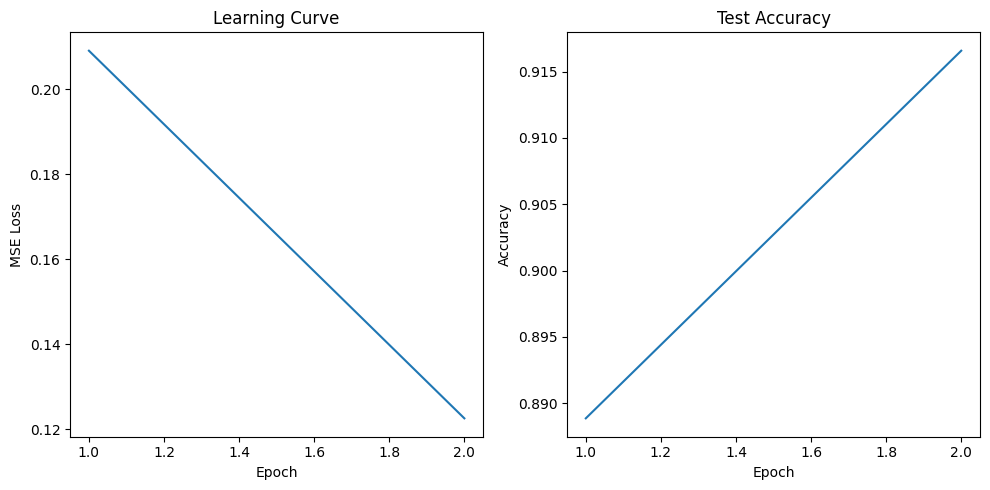

Epoch 3/10, Batch 0, Loss: 0.0992
Epoch 3/10, Batch 10, Loss: 0.1313
Epoch 3/10, Batch 20, Loss: 0.1070
Epoch 3/10, Batch 30, Loss: 0.1325
Epoch 3/10, Batch 40, Loss: 0.1121
Epoch 3/10, Batch 50, Loss: 0.1160
Epoch 3/10, Batch 60, Loss: 0.1175
Epoch 3/10, Batch 70, Loss: 0.0966
Epoch 3/10, Batch 80, Loss: 0.1057
Epoch 3/10, Batch 90, Loss: 0.1059
Epoch 3/10, Batch 100, Loss: 0.1009
Epoch 3/10, Batch 110, Loss: 0.1043
Epoch 3/10, Batch 120, Loss: 0.1312
Epoch 3/10, Batch 130, Loss: 0.1079
Epoch 3/10, Batch 140, Loss: 0.0903
Epoch 3/10, Batch 150, Loss: 0.0820
Epoch 3/10, Batch 160, Loss: 0.1107
Epoch 3/10, Batch 170, Loss: 0.0966
Epoch 3/10, Batch 180, Loss: 0.0934
Epoch 3/10, Batch 190, Loss: 0.1346
Epoch 3/10, Batch 200, Loss: 0.0759
Epoch 3/10, Batch 210, Loss: 0.1090
Epoch 3/10, Batch 220, Loss: 0.1071
Epoch 3/10, Batch 230, Loss: 0.1012
Epoch 3/10, Batch 240, Loss: 0.0913
Epoch 3/10, Batch 250, Loss: 0.0880
Epoch 3/10, Batch 260, Loss: 0.0977
Epoch 3/10, Batch 270, Loss: 0.0998
Epo

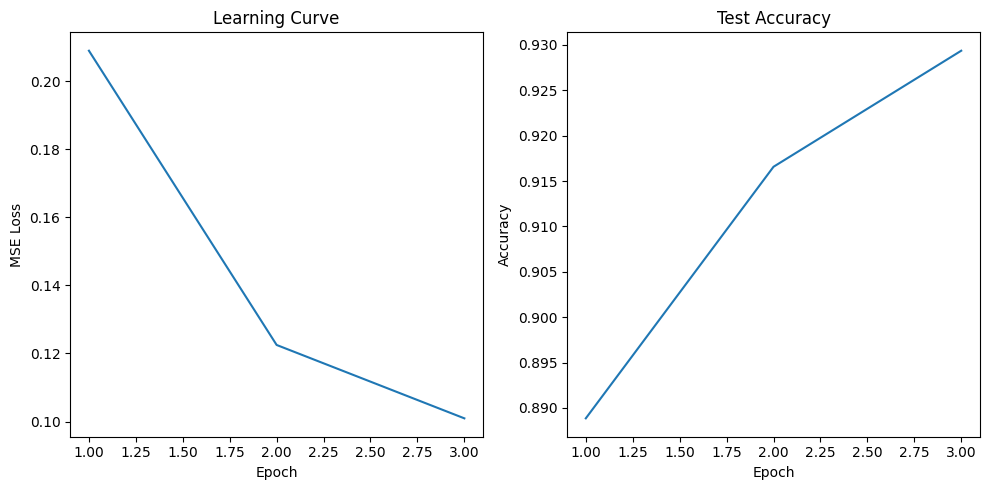

Epoch 4/10, Batch 0, Loss: 0.0849
Epoch 4/10, Batch 10, Loss: 0.1143
Epoch 4/10, Batch 20, Loss: 0.0946
Epoch 4/10, Batch 30, Loss: 0.1161
Epoch 4/10, Batch 40, Loss: 0.0976
Epoch 4/10, Batch 50, Loss: 0.1037
Epoch 4/10, Batch 60, Loss: 0.1031
Epoch 4/10, Batch 70, Loss: 0.0823
Epoch 4/10, Batch 80, Loss: 0.0921
Epoch 4/10, Batch 90, Loss: 0.0932
Epoch 4/10, Batch 100, Loss: 0.0896
Epoch 4/10, Batch 110, Loss: 0.0907
Epoch 4/10, Batch 120, Loss: 0.1174
Epoch 4/10, Batch 130, Loss: 0.0971
Epoch 4/10, Batch 140, Loss: 0.0809
Epoch 4/10, Batch 150, Loss: 0.0718
Epoch 4/10, Batch 160, Loss: 0.1000
Epoch 4/10, Batch 170, Loss: 0.0856
Epoch 4/10, Batch 180, Loss: 0.0826
Epoch 4/10, Batch 190, Loss: 0.1212
Epoch 4/10, Batch 200, Loss: 0.0661
Epoch 4/10, Batch 210, Loss: 0.0988
Epoch 4/10, Batch 220, Loss: 0.0954
Epoch 4/10, Batch 230, Loss: 0.0910
Epoch 4/10, Batch 240, Loss: 0.0818
Epoch 4/10, Batch 250, Loss: 0.0776
Epoch 4/10, Batch 260, Loss: 0.0873
Epoch 4/10, Batch 270, Loss: 0.0902
Epo

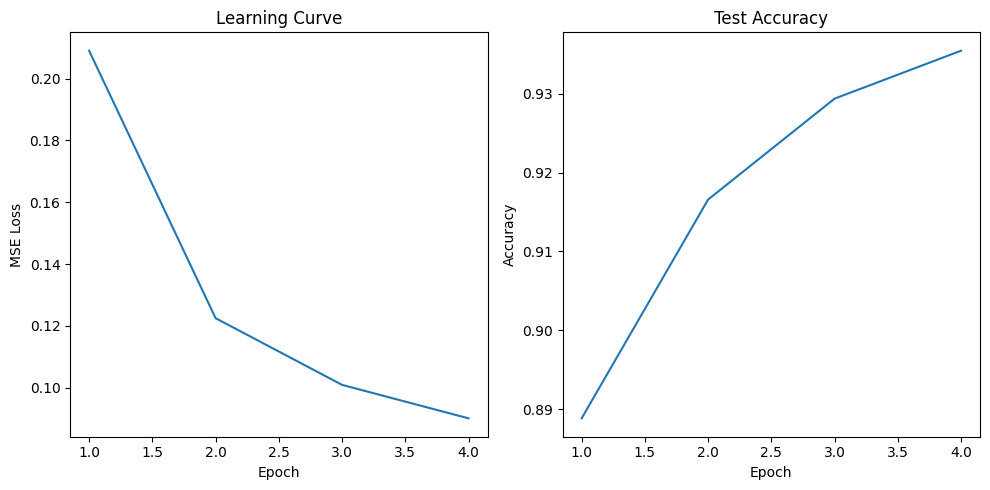

Epoch 5/10, Batch 0, Loss: 0.0768
Epoch 5/10, Batch 10, Loss: 0.1046
Epoch 5/10, Batch 20, Loss: 0.0874
Epoch 5/10, Batch 30, Loss: 0.1060
Epoch 5/10, Batch 40, Loss: 0.0888
Epoch 5/10, Batch 50, Loss: 0.0960
Epoch 5/10, Batch 60, Loss: 0.0941
Epoch 5/10, Batch 70, Loss: 0.0736
Epoch 5/10, Batch 80, Loss: 0.0842
Epoch 5/10, Batch 90, Loss: 0.0847
Epoch 5/10, Batch 100, Loss: 0.0823
Epoch 5/10, Batch 110, Loss: 0.0817
Epoch 5/10, Batch 120, Loss: 0.1082
Epoch 5/10, Batch 130, Loss: 0.0894
Epoch 5/10, Batch 140, Loss: 0.0750
Epoch 5/10, Batch 150, Loss: 0.0648
Epoch 5/10, Batch 160, Loss: 0.0925
Epoch 5/10, Batch 170, Loss: 0.0786
Epoch 5/10, Batch 180, Loss: 0.0752
Epoch 5/10, Batch 190, Loss: 0.1115
Epoch 5/10, Batch 200, Loss: 0.0603
Epoch 5/10, Batch 210, Loss: 0.0915
Epoch 5/10, Batch 220, Loss: 0.0875
Epoch 5/10, Batch 230, Loss: 0.0845
Epoch 5/10, Batch 240, Loss: 0.0756
Epoch 5/10, Batch 250, Loss: 0.0708
Epoch 5/10, Batch 260, Loss: 0.0802
Epoch 5/10, Batch 270, Loss: 0.0839
Epo

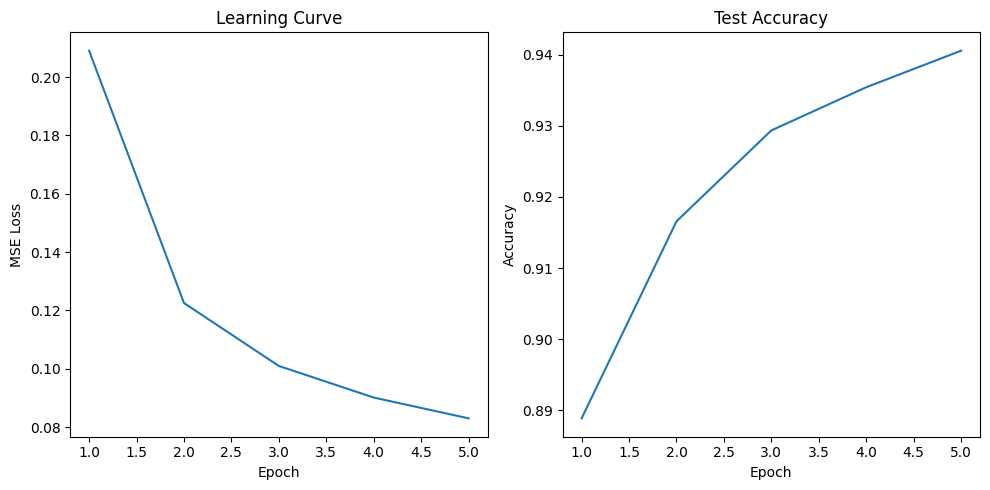

Epoch 6/10, Batch 0, Loss: 0.0713
Epoch 6/10, Batch 10, Loss: 0.0979
Epoch 6/10, Batch 20, Loss: 0.0821
Epoch 6/10, Batch 30, Loss: 0.0988
Epoch 6/10, Batch 40, Loss: 0.0825
Epoch 6/10, Batch 50, Loss: 0.0905
Epoch 6/10, Batch 60, Loss: 0.0877
Epoch 6/10, Batch 70, Loss: 0.0675
Epoch 6/10, Batch 80, Loss: 0.0791
Epoch 6/10, Batch 90, Loss: 0.0781
Epoch 6/10, Batch 100, Loss: 0.0770
Epoch 6/10, Batch 110, Loss: 0.0751
Epoch 6/10, Batch 120, Loss: 0.1015
Epoch 6/10, Batch 130, Loss: 0.0836
Epoch 6/10, Batch 140, Loss: 0.0704
Epoch 6/10, Batch 150, Loss: 0.0596
Epoch 6/10, Batch 160, Loss: 0.0869
Epoch 6/10, Batch 170, Loss: 0.0738
Epoch 6/10, Batch 180, Loss: 0.0696
Epoch 6/10, Batch 190, Loss: 0.1042
Epoch 6/10, Batch 200, Loss: 0.0564
Epoch 6/10, Batch 210, Loss: 0.0856
Epoch 6/10, Batch 220, Loss: 0.0814
Epoch 6/10, Batch 230, Loss: 0.0800
Epoch 6/10, Batch 240, Loss: 0.0711
Epoch 6/10, Batch 250, Loss: 0.0656
Epoch 6/10, Batch 260, Loss: 0.0751
Epoch 6/10, Batch 270, Loss: 0.0792
Epo

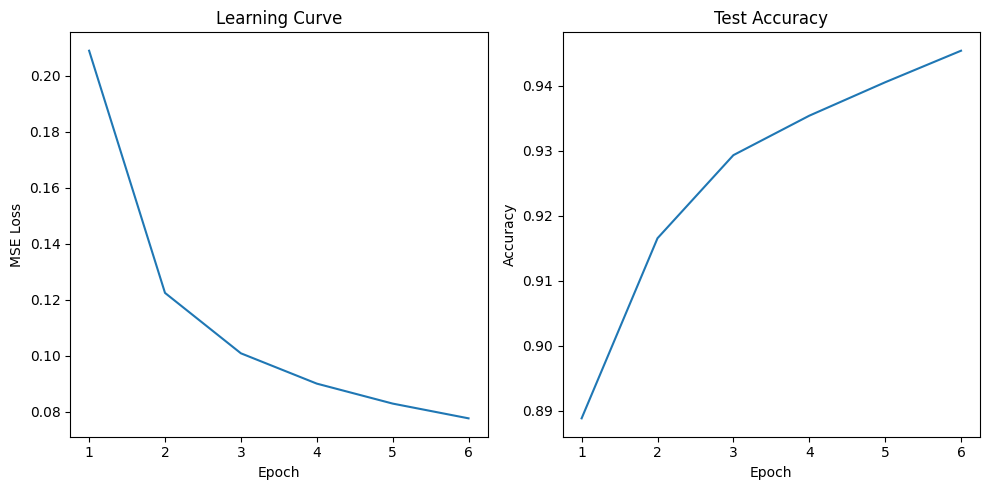

Epoch 7/10, Batch 0, Loss: 0.0668
Epoch 7/10, Batch 10, Loss: 0.0928
Epoch 7/10, Batch 20, Loss: 0.0780
Epoch 7/10, Batch 30, Loss: 0.0934
Epoch 7/10, Batch 40, Loss: 0.0778
Epoch 7/10, Batch 50, Loss: 0.0864
Epoch 7/10, Batch 60, Loss: 0.0829
Epoch 7/10, Batch 70, Loss: 0.0630
Epoch 7/10, Batch 80, Loss: 0.0751
Epoch 7/10, Batch 90, Loss: 0.0729
Epoch 7/10, Batch 100, Loss: 0.0729
Epoch 7/10, Batch 110, Loss: 0.0700
Epoch 7/10, Batch 120, Loss: 0.0962
Epoch 7/10, Batch 130, Loss: 0.0790
Epoch 7/10, Batch 140, Loss: 0.0669
Epoch 7/10, Batch 150, Loss: 0.0554
Epoch 7/10, Batch 160, Loss: 0.0822
Epoch 7/10, Batch 170, Loss: 0.0703
Epoch 7/10, Batch 180, Loss: 0.0652
Epoch 7/10, Batch 190, Loss: 0.0985
Epoch 7/10, Batch 200, Loss: 0.0534
Epoch 7/10, Batch 210, Loss: 0.0807
Epoch 7/10, Batch 220, Loss: 0.0767
Epoch 7/10, Batch 230, Loss: 0.0766
Epoch 7/10, Batch 240, Loss: 0.0674
Epoch 7/10, Batch 250, Loss: 0.0613
Epoch 7/10, Batch 260, Loss: 0.0711
Epoch 7/10, Batch 270, Loss: 0.0753
Epo

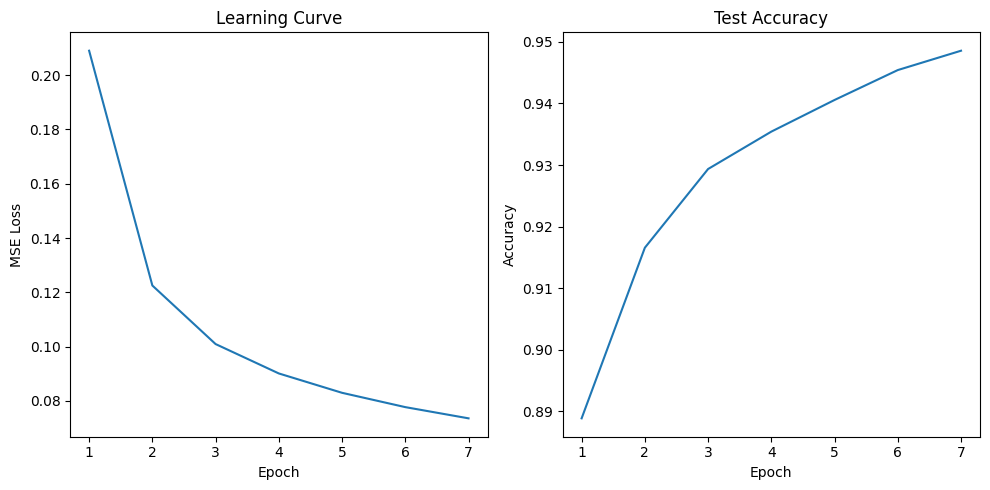

Epoch 8/10, Batch 0, Loss: 0.0632
Epoch 8/10, Batch 10, Loss: 0.0887
Epoch 8/10, Batch 20, Loss: 0.0744
Epoch 8/10, Batch 30, Loss: 0.0890
Epoch 8/10, Batch 40, Loss: 0.0741
Epoch 8/10, Batch 50, Loss: 0.0832
Epoch 8/10, Batch 60, Loss: 0.0790
Epoch 8/10, Batch 70, Loss: 0.0594
Epoch 8/10, Batch 80, Loss: 0.0719
Epoch 8/10, Batch 90, Loss: 0.0688
Epoch 8/10, Batch 100, Loss: 0.0696
Epoch 8/10, Batch 110, Loss: 0.0659
Epoch 8/10, Batch 120, Loss: 0.0919
Epoch 8/10, Batch 130, Loss: 0.0752
Epoch 8/10, Batch 140, Loss: 0.0642
Epoch 8/10, Batch 150, Loss: 0.0521
Epoch 8/10, Batch 160, Loss: 0.0782
Epoch 8/10, Batch 170, Loss: 0.0673
Epoch 8/10, Batch 180, Loss: 0.0614
Epoch 8/10, Batch 190, Loss: 0.0938
Epoch 8/10, Batch 200, Loss: 0.0511
Epoch 8/10, Batch 210, Loss: 0.0765
Epoch 8/10, Batch 220, Loss: 0.0729
Epoch 8/10, Batch 230, Loss: 0.0739
Epoch 8/10, Batch 240, Loss: 0.0644
Epoch 8/10, Batch 250, Loss: 0.0578
Epoch 8/10, Batch 260, Loss: 0.0680
Epoch 8/10, Batch 270, Loss: 0.0721
Epo

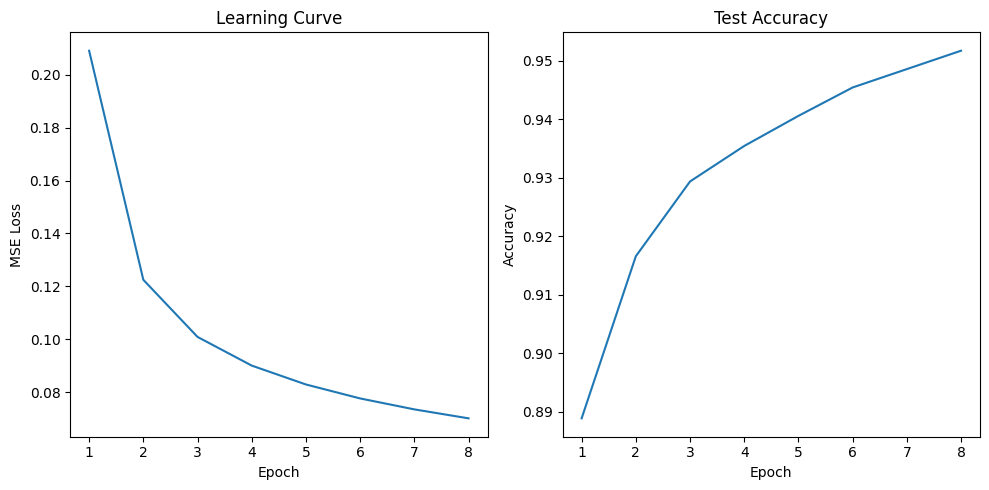

Epoch 9/10, Batch 0, Loss: 0.0601
Epoch 9/10, Batch 10, Loss: 0.0853
Epoch 9/10, Batch 20, Loss: 0.0714
Epoch 9/10, Batch 30, Loss: 0.0853
Epoch 9/10, Batch 40, Loss: 0.0710
Epoch 9/10, Batch 50, Loss: 0.0803
Epoch 9/10, Batch 60, Loss: 0.0760
Epoch 9/10, Batch 70, Loss: 0.0563
Epoch 9/10, Batch 80, Loss: 0.0691
Epoch 9/10, Batch 90, Loss: 0.0655
Epoch 9/10, Batch 100, Loss: 0.0670
Epoch 9/10, Batch 110, Loss: 0.0626
Epoch 9/10, Batch 120, Loss: 0.0884
Epoch 9/10, Batch 130, Loss: 0.0720
Epoch 9/10, Batch 140, Loss: 0.0620
Epoch 9/10, Batch 150, Loss: 0.0495
Epoch 9/10, Batch 160, Loss: 0.0749
Epoch 9/10, Batch 170, Loss: 0.0649
Epoch 9/10, Batch 180, Loss: 0.0582
Epoch 9/10, Batch 190, Loss: 0.0900
Epoch 9/10, Batch 200, Loss: 0.0492
Epoch 9/10, Batch 210, Loss: 0.0729
Epoch 9/10, Batch 220, Loss: 0.0697
Epoch 9/10, Batch 230, Loss: 0.0718
Epoch 9/10, Batch 240, Loss: 0.0619
Epoch 9/10, Batch 250, Loss: 0.0548
Epoch 9/10, Batch 260, Loss: 0.0653
Epoch 9/10, Batch 270, Loss: 0.0695
Epo

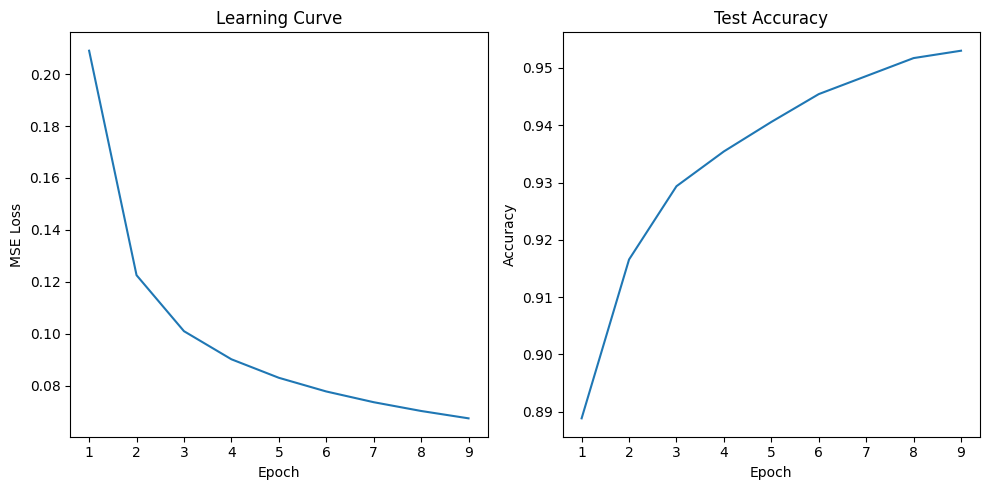

Epoch 10/10, Batch 0, Loss: 0.0575
Epoch 10/10, Batch 10, Loss: 0.0822
Epoch 10/10, Batch 20, Loss: 0.0688
Epoch 10/10, Batch 30, Loss: 0.0822
Epoch 10/10, Batch 40, Loss: 0.0682
Epoch 10/10, Batch 50, Loss: 0.0779
Epoch 10/10, Batch 60, Loss: 0.0734
Epoch 10/10, Batch 70, Loss: 0.0537
Epoch 10/10, Batch 80, Loss: 0.0667
Epoch 10/10, Batch 90, Loss: 0.0626
Epoch 10/10, Batch 100, Loss: 0.0648
Epoch 10/10, Batch 110, Loss: 0.0599
Epoch 10/10, Batch 120, Loss: 0.0856
Epoch 10/10, Batch 130, Loss: 0.0692
Epoch 10/10, Batch 140, Loss: 0.0603
Epoch 10/10, Batch 150, Loss: 0.0473
Epoch 10/10, Batch 160, Loss: 0.0720
Epoch 10/10, Batch 170, Loss: 0.0628
Epoch 10/10, Batch 180, Loss: 0.0555
Epoch 10/10, Batch 190, Loss: 0.0868
Epoch 10/10, Batch 200, Loss: 0.0477
Epoch 10/10, Batch 210, Loss: 0.0699
Epoch 10/10, Batch 220, Loss: 0.0672
Epoch 10/10, Batch 230, Loss: 0.0699
Epoch 10/10, Batch 240, Loss: 0.0598
Epoch 10/10, Batch 250, Loss: 0.0522
Epoch 10/10, Batch 260, Loss: 0.0630
Epoch 10/10,

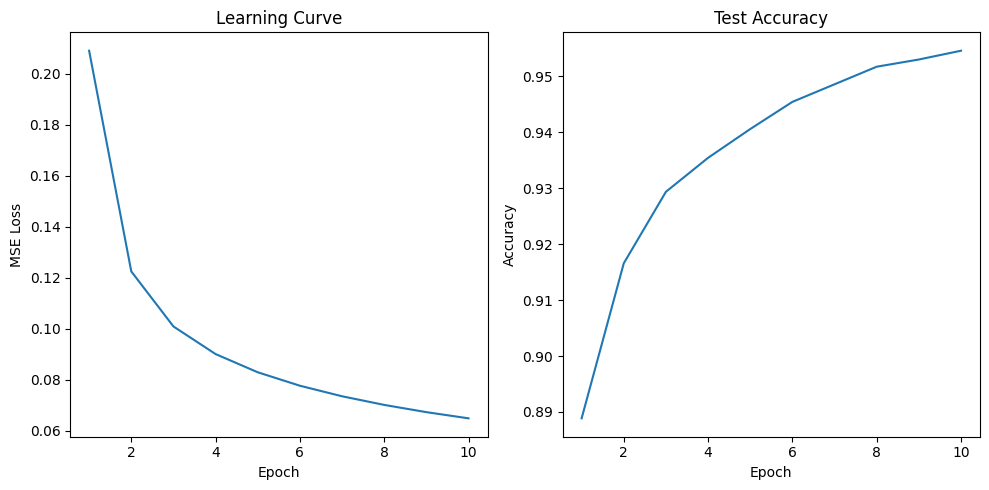

Training completed. Generating final visualizations...


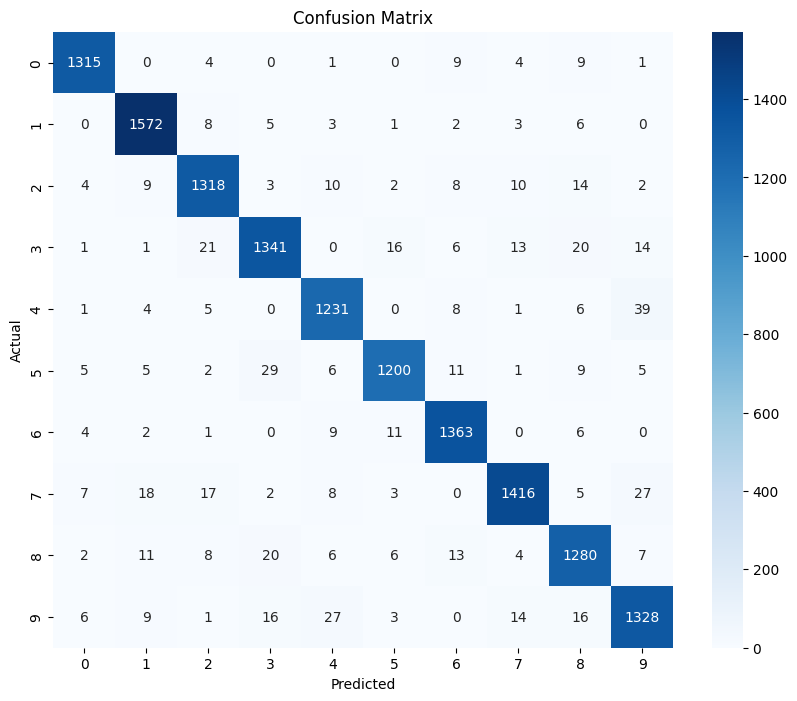

All done!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

class FeedbackAlignmentMLP:
    def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
        # Forward weights
        self.W = np.random.normal(0, sigma, (input_size, hidden_size))
        self.W_out = np.random.normal(0, sigma, (hidden_size, output_size))

        # Feedback weights (random and fixed)
        self.B = np.random.normal(0, sigma, (output_size, hidden_size))

    def forward(self, X):
        self.h = np.maximum(0, X @ self.W)  # ReLU activation
        self.y_hat = self.h @ self.W_out
        return self.y_hat

    def loss(self, X, targets):
        y_hat = self.forward(X)
        return 0.5 * np.mean(np.sum((targets - y_hat) ** 2, axis=1))

    def feedback_alignment_update(self, X, targets, eta):
        # Forward pass
        y_hat = self.forward(X)

        # Error
        e = targets - y_hat

        # Feedback alignment update
        delta = e @ self.B

        # Weight updates
        dW = eta * (X.T @ (delta * (self.h > 0)))  # ReLU derivative
        dW_out = eta * (self.h.T @ e)

        return dW, dW_out

# Load and preprocess MNIST data
print("Loading MNIST data...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Initialize model
model = FeedbackAlignmentMLP(784, 500, 10, sigma=0.01)

# Training parameters
epochs = 10
batch_size = 128
eta = 0.001  # learning rate

# Training loop
losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(epochs):
    epoch_losses = []
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train_onehot[i:i+batch_size]

        dW, dW_out = model.feedback_alignment_update(batch_X, batch_y, eta)

        model.W += dW
        model.W_out += dW_out

        batch_loss = model.loss(batch_X, batch_y)
        epoch_losses.append(batch_loss)

        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {batch_loss:.4f}")

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)

    # Evaluate on test set
    y_pred = model.forward(X_test)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Plot learning curve after each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

print("Training completed. Generating final visualizations...")

# Final Confusion Matrix
y_pred = model.forward(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("All done!")




Feedback Alignment In A Non Stationary Learning Environment

Inferences:

1) Model seems to remember it's "previous learnings"


Questions:

1) What motivates the improved generalisation after epoch 10

Loading MNIST data...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Starting non-stationary learning...
Epoch 1/15, Loss: 0.1245, Accuracy: 0.4800


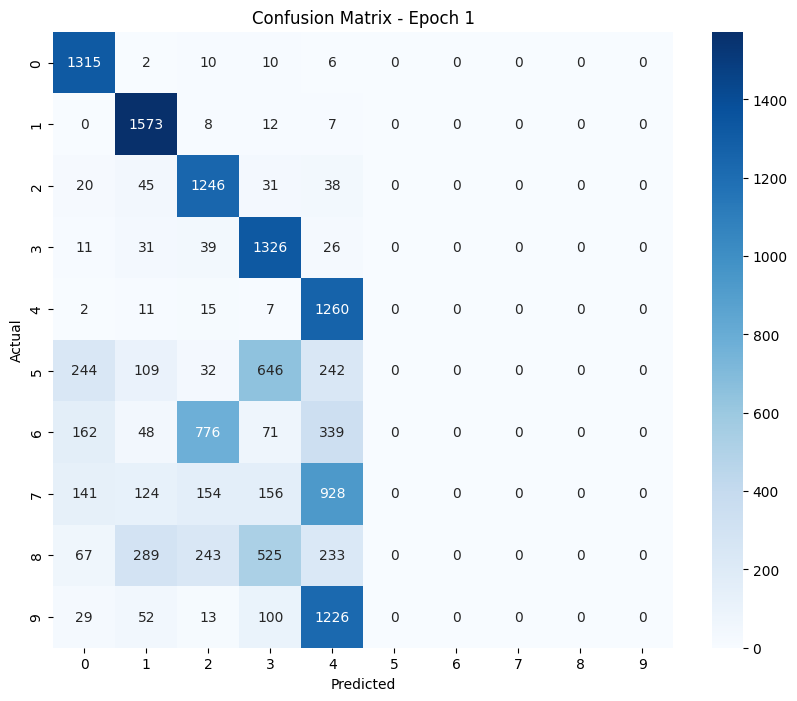

Epoch 2/15, Loss: 0.0664, Accuracy: 0.4853


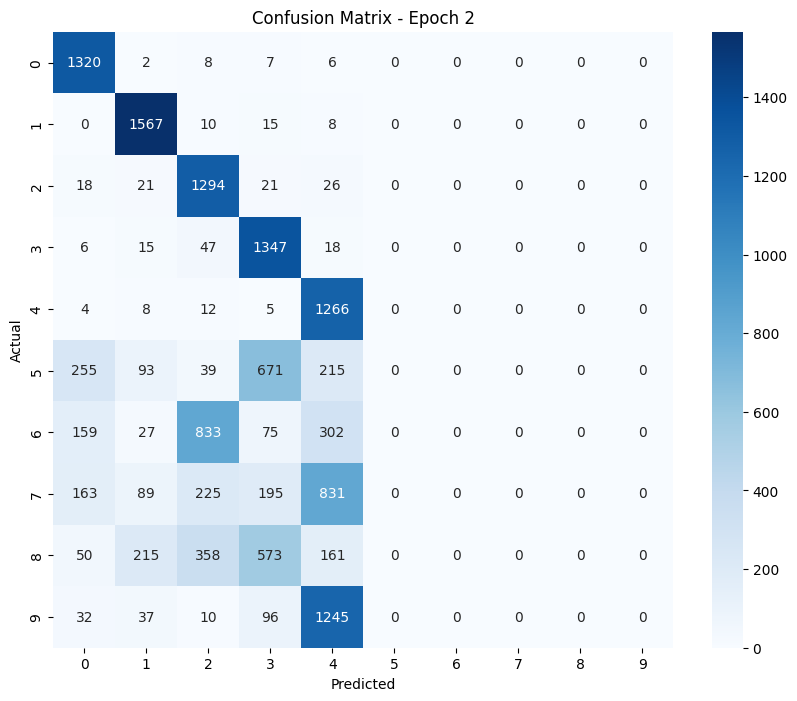

Epoch 3/15, Loss: 0.0550, Accuracy: 0.4877


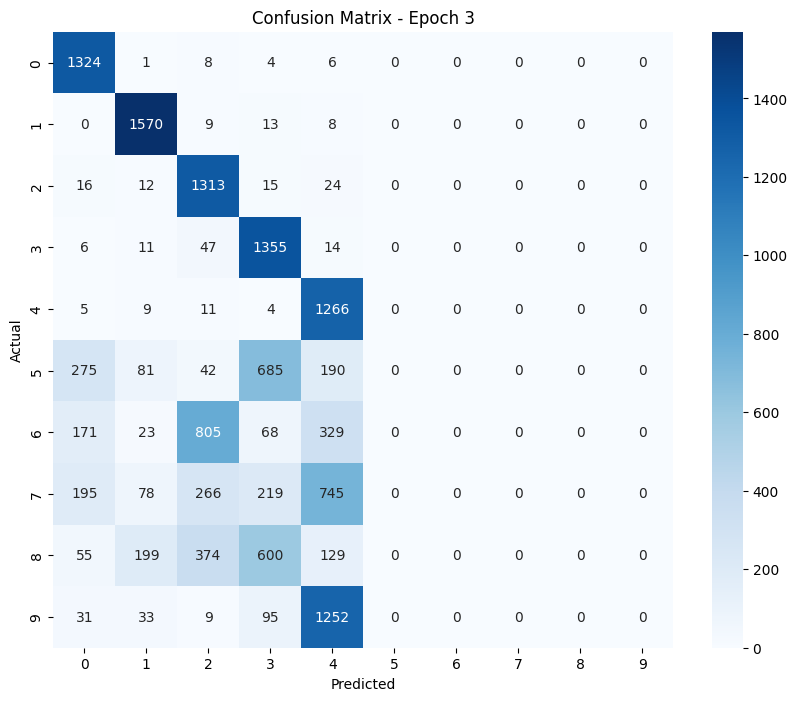

Epoch 4/15, Loss: 0.0489, Accuracy: 0.4896


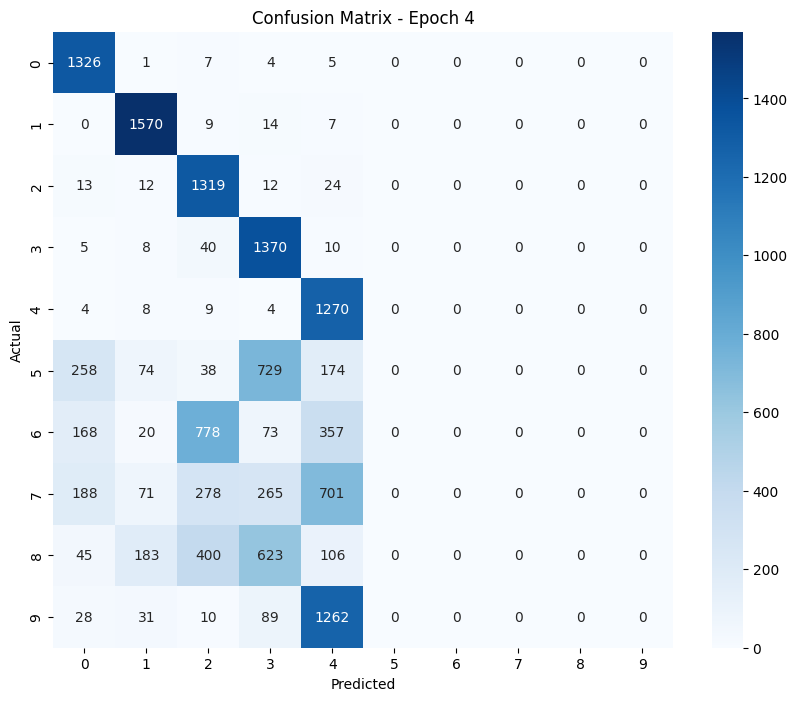

Epoch 5/15, Loss: 0.0447, Accuracy: 0.4907


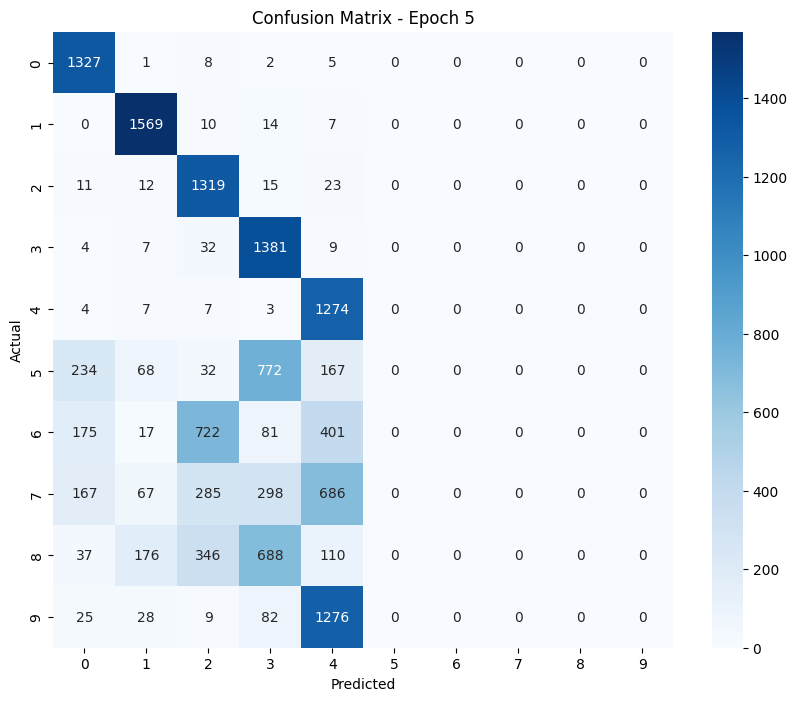

Epoch 6/15, Loss: 0.5694, Accuracy: 0.7539


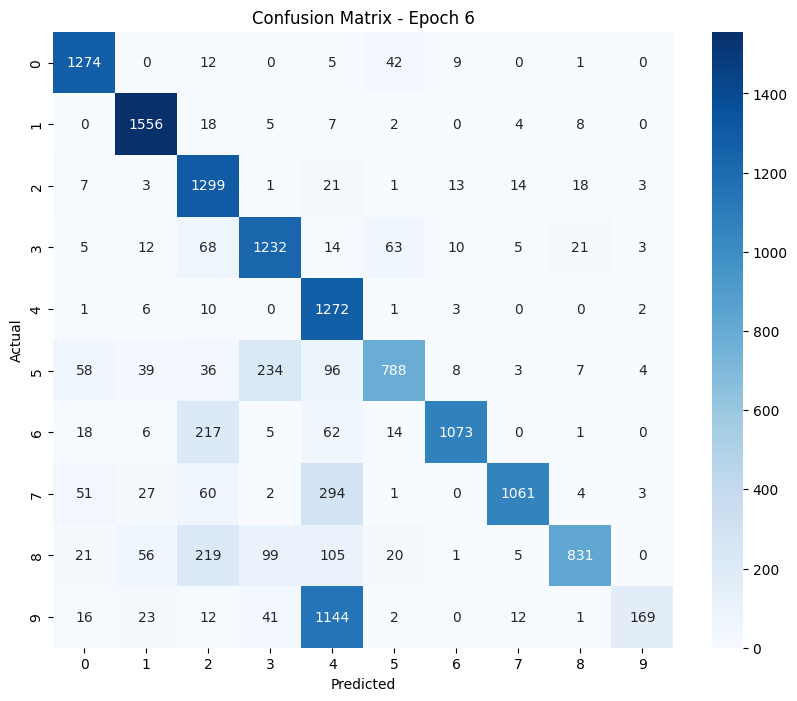

Epoch 7/15, Loss: 0.5066, Accuracy: 0.8044


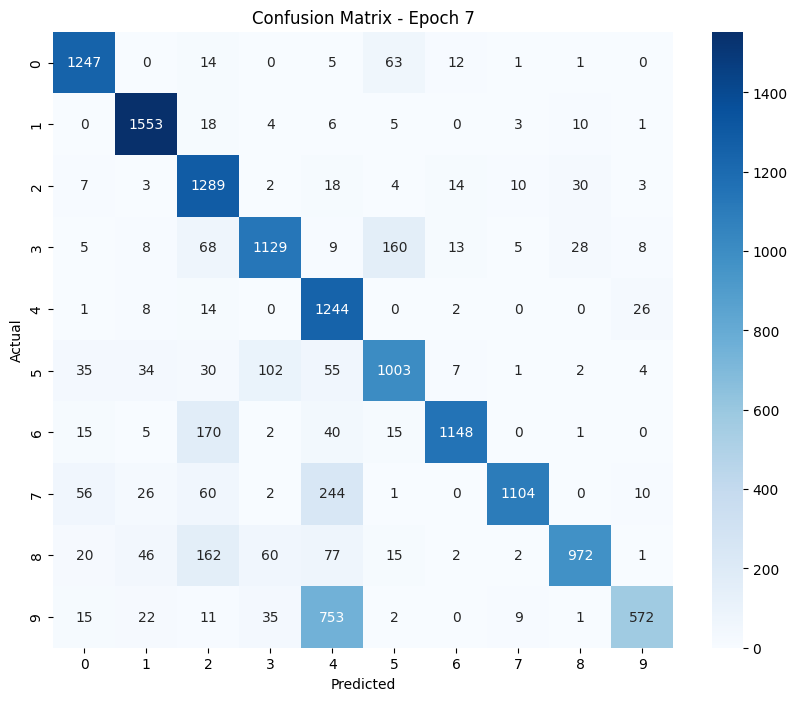

Epoch 8/15, Loss: 0.4679, Accuracy: 0.8221


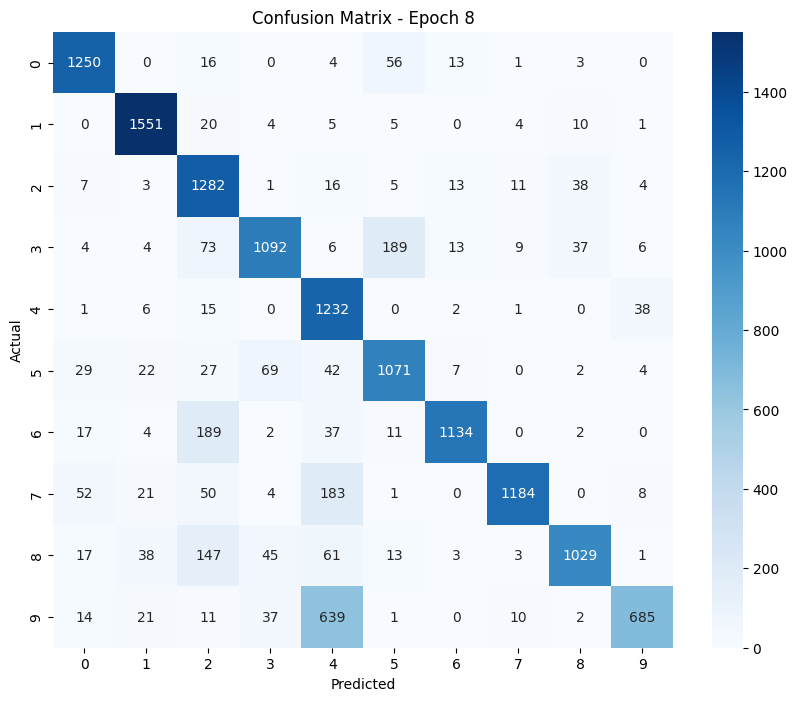

Epoch 9/15, Loss: 0.4498, Accuracy: 0.8385


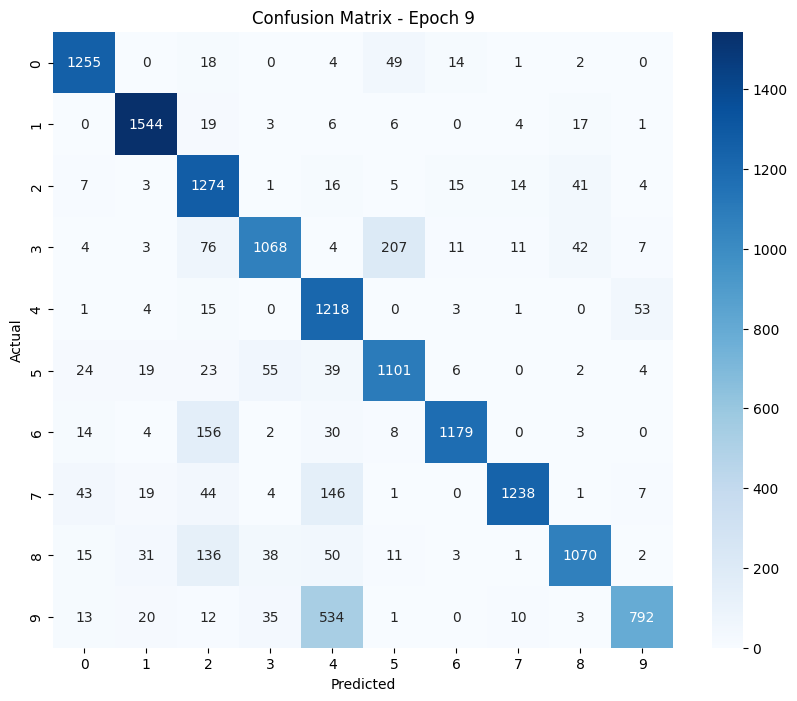

Epoch 10/15, Loss: 0.4408, Accuracy: 0.8442


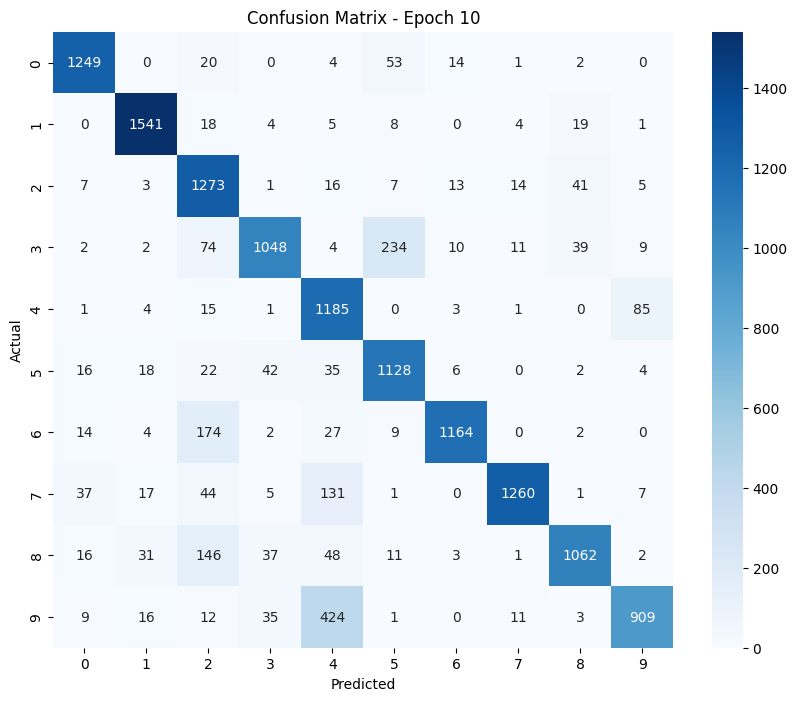

Epoch 11/15, Loss: 0.1202, Accuracy: 0.9314


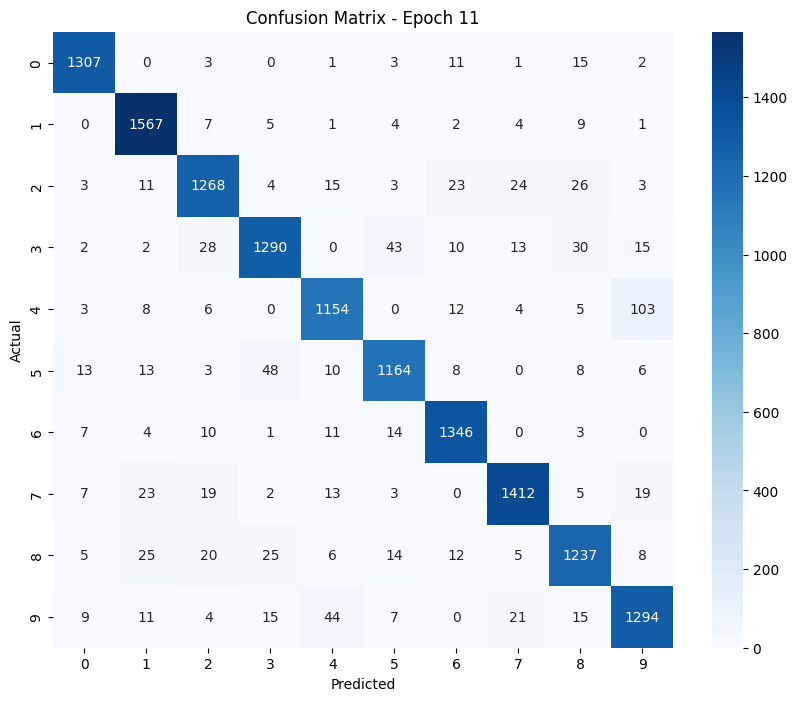

Epoch 12/15, Loss: 0.0913, Accuracy: 0.9368


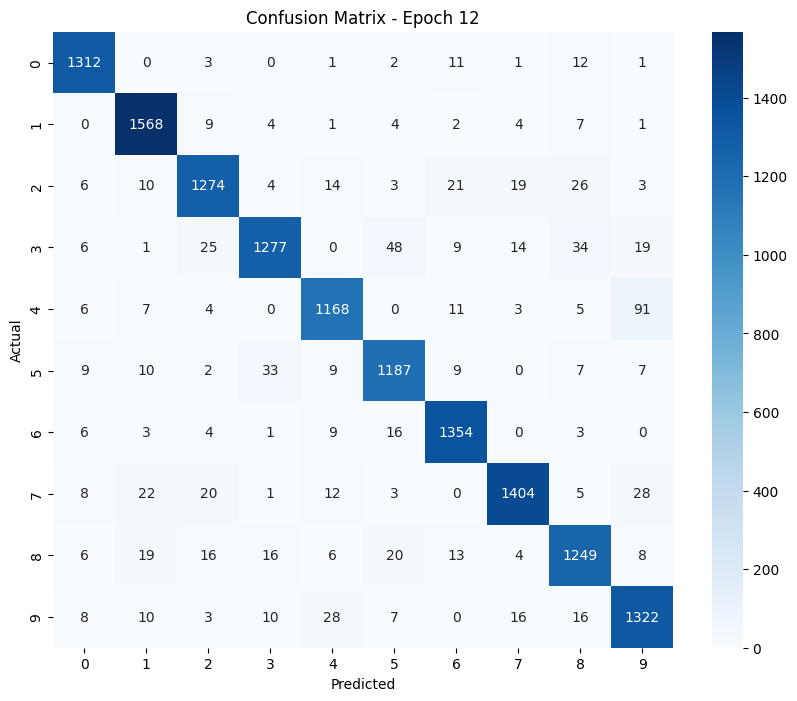

Epoch 13/15, Loss: 0.0823, Accuracy: 0.9429


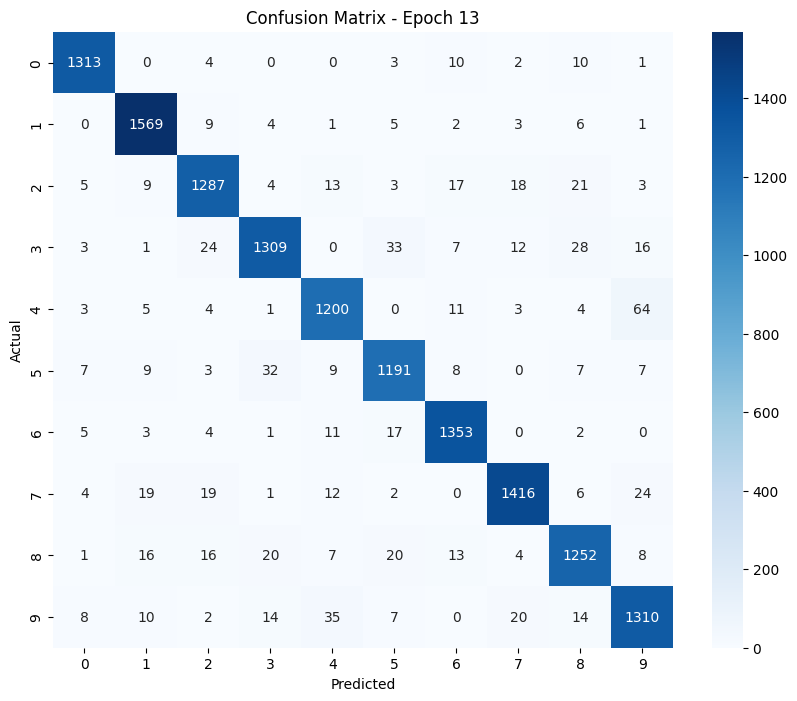

Epoch 14/15, Loss: 0.0767, Accuracy: 0.9469


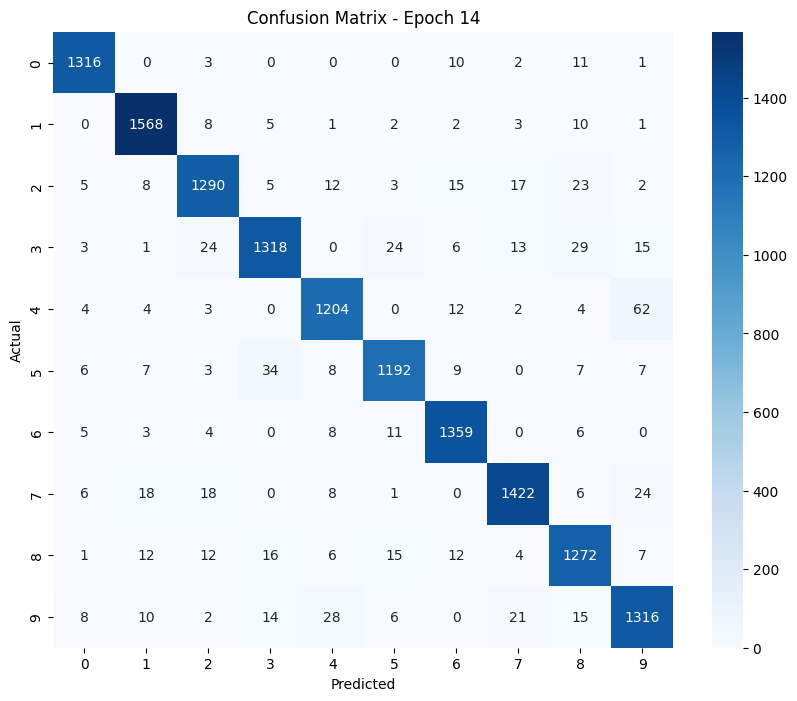

Epoch 15/15, Loss: 0.0726, Accuracy: 0.9494


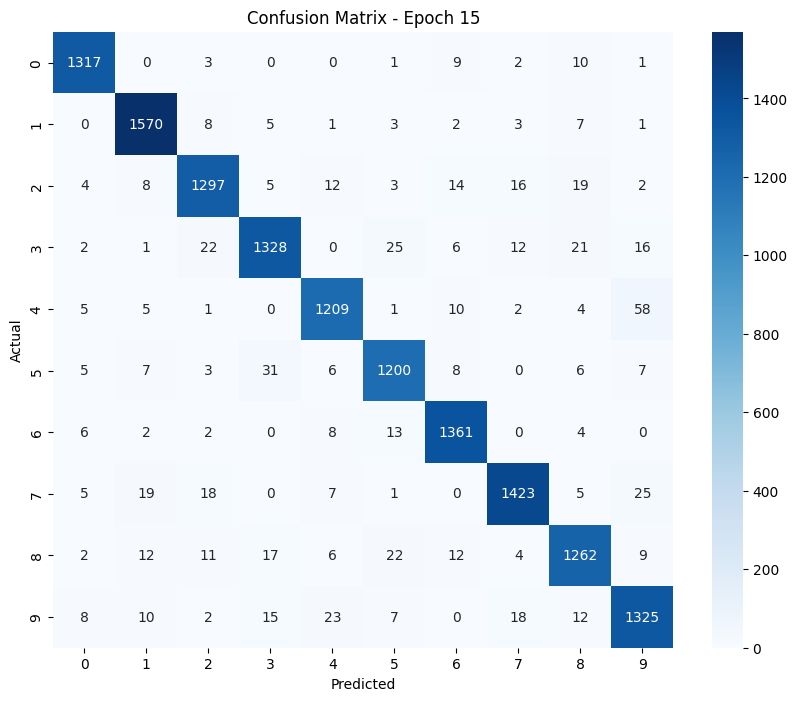

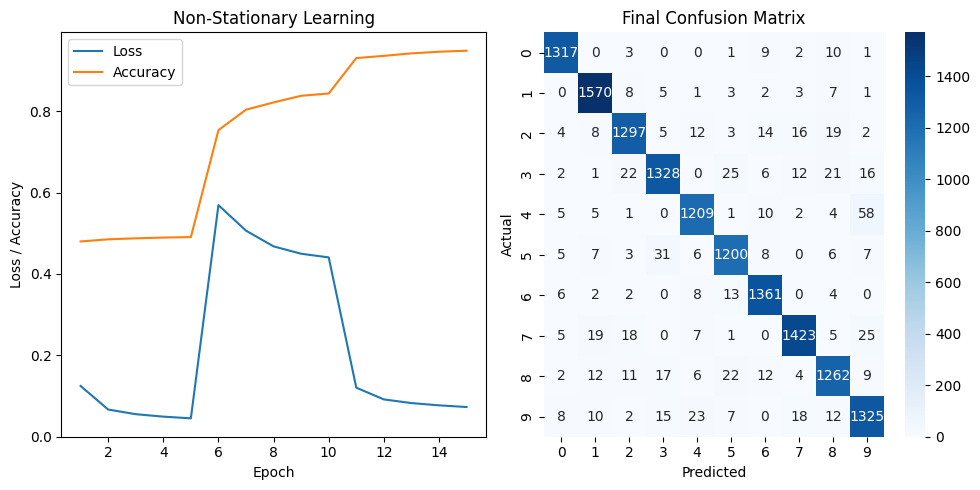

Non-stationary learning experiment completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

class FeedbackAlignmentMLP:
    def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Forward weights
        self.W = np.random.normal(0, sigma, (input_size, hidden_size))
        self.W_out = np.random.normal(0, sigma, (hidden_size, output_size))

        # Feedback weights (random and fixed)
        self.B = np.random.normal(0, sigma, (output_size, hidden_size))

    def forward(self, X):
        self.h = np.maximum(0, X @ self.W)  # ReLU activation
        self.y_hat = self.h @ self.W_out
        return self.y_hat

    def loss(self, X, targets):
        y_hat = self.forward(X)
        return 0.5 * np.mean(np.sum((targets - y_hat) ** 2, axis=1))

    def feedback_alignment_update(self, X, targets, eta, active_outputs):
        # Forward pass
        y_hat = self.forward(X)

        # Error
        e = np.zeros_like(y_hat)
        e[:, active_outputs] = targets[:, active_outputs] - y_hat[:, active_outputs]

        # Feedback alignment update
        delta = e @ self.B

        # Weight updates
        dW = eta * (X.T @ (delta * (self.h > 0)))  # ReLU derivative
        dW_out = eta * (self.h.T @ e)

        self.W += dW
        self.W_out += dW_out

def add_noise(X, noise_level):
    return X + np.random.normal(0, noise_level, X.shape)

# Load and preprocess MNIST data
print("Loading MNIST data...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = FeedbackAlignmentMLP(784, 500, 10, sigma=0.01)

# Training parameters
total_epochs = 15
eta = 0.001  # learning rate

# Non-Stationary Learning
print("Starting non-stationary learning...")
losses = []
accuracies = []

# Training loop
for epoch in range(total_epochs):
    epoch_losses = []

    # Determine active classes for this epoch
    if epoch < 5:
        active_classes = range(5)  # First 5 epochs: train on digits 0-4
    elif epoch < 10:
        active_classes = range(5, 10)  # Next 5 epochs: train on digits 5-9
    else:
        active_classes = range(10)  # Last 5 epochs: train on all digits

    # Create mini-batches
    batch_size = 32
    indices = np.random.permutation(len(X_train))
    for start_idx in range(0, len(X_train), batch_size):
        batch_indices = indices[start_idx:start_idx+batch_size]
        batch_X = X_train[batch_indices]
        batch_y = y_train[batch_indices]

        # Filter samples for active classes
        mask = np.isin(batch_y, active_classes)
        batch_X = batch_X[mask]
        batch_y = batch_y[mask]

        if len(batch_y) == 0:
            continue  # Skip empty batches

        # Convert labels to one-hot encoding
        batch_y_onehot = np.zeros((len(batch_y), 10))
        batch_y_onehot[np.arange(len(batch_y)), batch_y] = 1

        # Update weights
        model.feedback_alignment_update(batch_X, batch_y_onehot, eta, active_classes)

        # Compute loss
        batch_loss = model.loss(batch_X, batch_y_onehot)
        epoch_losses.append(batch_loss)

    avg_epoch_loss = np.mean(epoch_losses)
    losses.append(avg_epoch_loss)

    # Evaluate on test set
    y_pred = model.forward(X_test)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Print confusion matrix after each epoch
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plotting final results
plt.figure(figsize=(10, 5))

# Learning curve
plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs+1), losses, label='Loss')
plt.plot(range(1, total_epochs+1), accuracies, label='Accuracy')
plt.title('Non-Stationary Learning')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()

# Final Confusion Matrix
y_pred = model.forward(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Final Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

print("Non-stationary learning experiment completed!")

Loading MNIST data...
Starting non-stationary learning...
Epoch 1/15, Batch 0, Loss: 2.3026
Epoch 1/15, Batch 10, Loss: 2.3010
Epoch 1/15, Batch 20, Loss: 2.2982
Epoch 1/15, Batch 30, Loss: 2.2947
Epoch 1/15, Batch 40, Loss: 2.2941
Epoch 1/15, Batch 50, Loss: 2.2894
Epoch 1/15, Batch 60, Loss: 2.2943
Epoch 1/15, Batch 70, Loss: 2.2970
Epoch 1/15, Batch 80, Loss: 2.2812
Epoch 1/15, Batch 90, Loss: 2.2860
Epoch 1/15, Batch 100, Loss: 2.2820
Epoch 1/15, Batch 110, Loss: 2.2772
Epoch 1/15, Batch 120, Loss: 2.2788
Epoch 1/15, Batch 130, Loss: 2.2723
Epoch 1/15, Batch 140, Loss: 2.2726
Epoch 1/15, Batch 150, Loss: 2.2658
Epoch 1/15, Batch 160, Loss: 2.2625
Epoch 1/15, Batch 170, Loss: 2.2633
Epoch 1/15, Batch 180, Loss: 2.2634
Epoch 1/15, Batch 190, Loss: 2.2614
Epoch 1/15, Batch 200, Loss: 2.2599
Epoch 1/15, Batch 210, Loss: 2.2572
Epoch 1/15, Batch 220, Loss: 2.2542
Epoch 1/15, Batch 230, Loss: 2.2429
Epoch 1/15, Batch 240, Loss: 2.2411
Epoch 1/15, Batch 250, Loss: 2.2298
Epoch 1/15, Batch

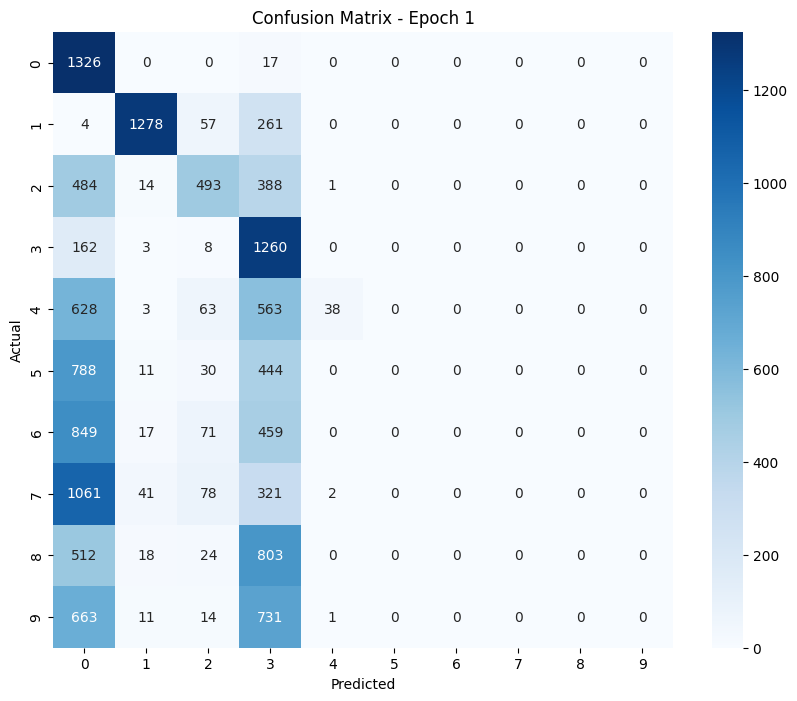

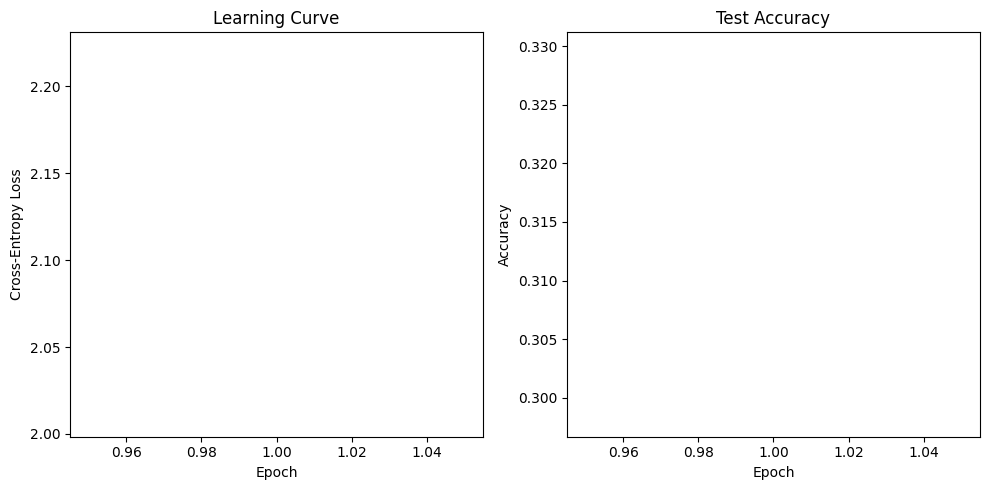

Epoch 2/15, Batch 0, Loss: 1.8530
Epoch 2/15, Batch 10, Loss: 1.7810
Epoch 2/15, Batch 20, Loss: 1.8392
Epoch 2/15, Batch 30, Loss: 1.7975
Epoch 2/15, Batch 40, Loss: 1.7579
Epoch 2/15, Batch 50, Loss: 1.6940
Epoch 2/15, Batch 60, Loss: 1.7734
Epoch 2/15, Batch 70, Loss: 1.7718
Epoch 2/15, Batch 80, Loss: 1.7517
Epoch 2/15, Batch 90, Loss: 1.7916
Epoch 2/15, Batch 100, Loss: 1.7390
Epoch 2/15, Batch 110, Loss: 1.7363
Epoch 2/15, Batch 120, Loss: 1.6598
Epoch 2/15, Batch 130, Loss: 1.6902
Epoch 2/15, Batch 140, Loss: 1.7209
Epoch 2/15, Batch 150, Loss: 1.6695
Epoch 2/15, Batch 160, Loss: 1.6836
Epoch 2/15, Batch 170, Loss: 1.6838
Epoch 2/15, Batch 180, Loss: 1.6855
Epoch 2/15, Batch 190, Loss: 1.7239
Epoch 2/15, Batch 200, Loss: 1.6680
Epoch 2/15, Batch 210, Loss: 1.6318
Epoch 2/15, Batch 220, Loss: 1.6720
Epoch 2/15, Batch 230, Loss: 1.6810
Epoch 2/15, Batch 240, Loss: 1.6275
Epoch 2/15, Batch 250, Loss: 1.5740
Epoch 2/15, Batch 260, Loss: 1.5949
Epoch 2/15, Batch 270, Loss: 1.6035
Epo

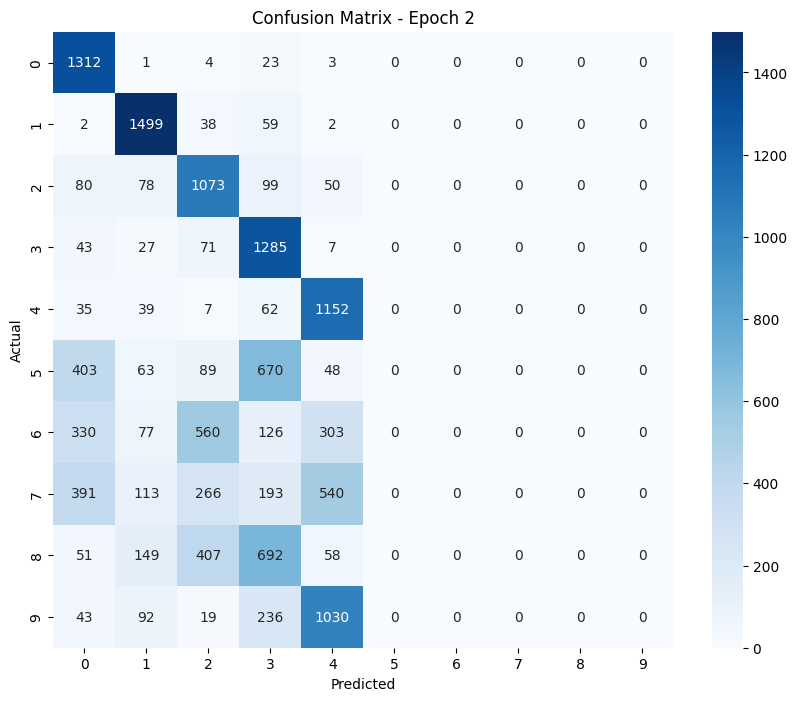

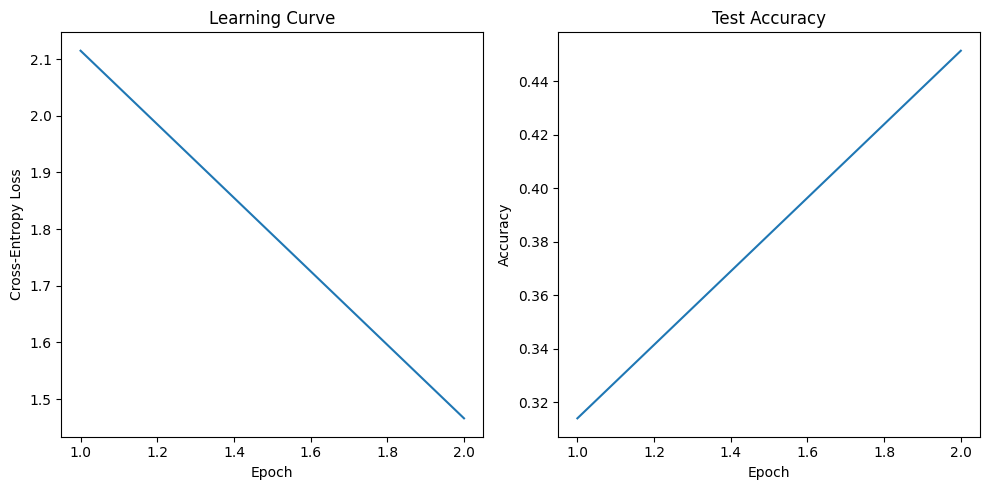

Epoch 3/15, Batch 0, Loss: 1.2142
Epoch 3/15, Batch 10, Loss: 1.1348
Epoch 3/15, Batch 20, Loss: 1.2133
Epoch 3/15, Batch 30, Loss: 1.1975
Epoch 3/15, Batch 40, Loss: 1.0442
Epoch 3/15, Batch 50, Loss: 1.0647
Epoch 3/15, Batch 60, Loss: 1.1034
Epoch 3/15, Batch 70, Loss: 1.0505
Epoch 3/15, Batch 80, Loss: 1.1299
Epoch 3/15, Batch 90, Loss: 1.1337
Epoch 3/15, Batch 100, Loss: 1.1088
Epoch 3/15, Batch 110, Loss: 1.1089
Epoch 3/15, Batch 120, Loss: 0.9596
Epoch 3/15, Batch 130, Loss: 1.0319
Epoch 3/15, Batch 140, Loss: 1.0509
Epoch 3/15, Batch 150, Loss: 1.0726
Epoch 3/15, Batch 160, Loss: 0.9856
Epoch 3/15, Batch 170, Loss: 1.0815
Epoch 3/15, Batch 180, Loss: 1.0888
Epoch 3/15, Batch 190, Loss: 1.0798
Epoch 3/15, Batch 200, Loss: 1.0359
Epoch 3/15, Batch 210, Loss: 0.9801
Epoch 3/15, Batch 220, Loss: 1.0406
Epoch 3/15, Batch 230, Loss: 1.1042
Epoch 3/15, Batch 240, Loss: 0.9873
Epoch 3/15, Batch 250, Loss: 0.9752
Epoch 3/15, Batch 260, Loss: 0.9660
Epoch 3/15, Batch 270, Loss: 0.9769
Epo

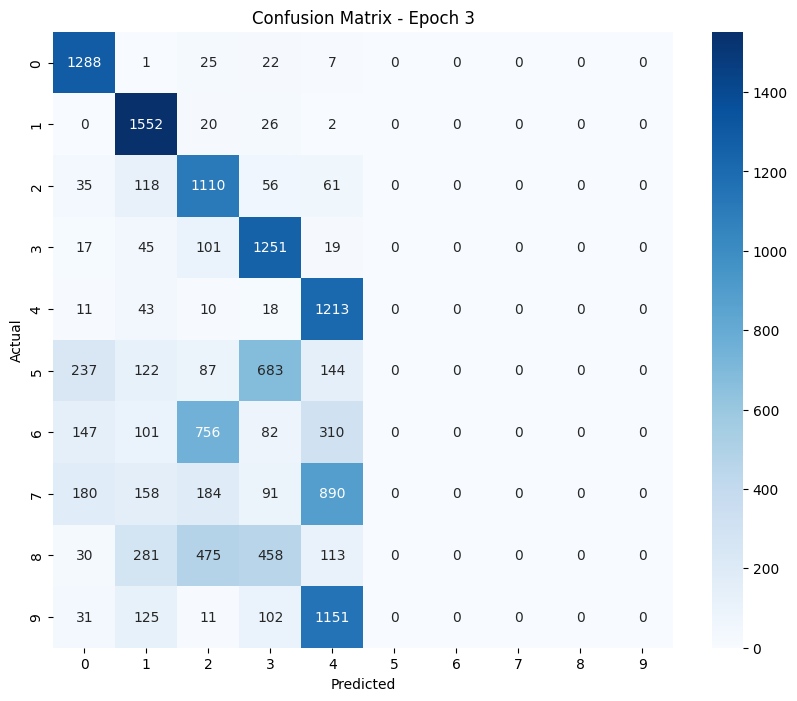

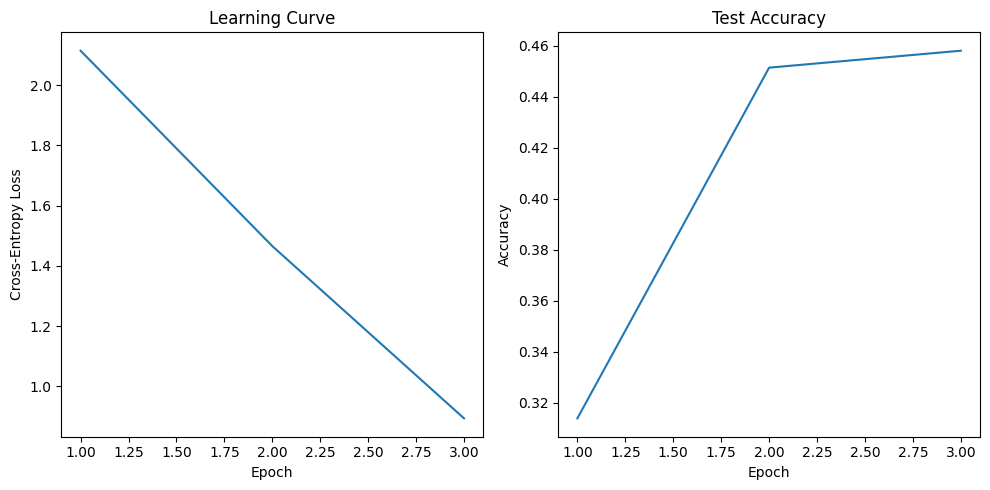

Epoch 4/15, Batch 0, Loss: 0.7215
Epoch 4/15, Batch 10, Loss: 0.7042
Epoch 4/15, Batch 20, Loss: 0.7817
Epoch 4/15, Batch 30, Loss: 0.7952
Epoch 4/15, Batch 40, Loss: 0.5346
Epoch 4/15, Batch 50, Loss: 0.6154
Epoch 4/15, Batch 60, Loss: 0.6568
Epoch 4/15, Batch 70, Loss: 0.5400
Epoch 4/15, Batch 80, Loss: 0.7001
Epoch 4/15, Batch 90, Loss: 0.6460
Epoch 4/15, Batch 100, Loss: 0.6907
Epoch 4/15, Batch 110, Loss: 0.6693
Epoch 4/15, Batch 120, Loss: 0.5135
Epoch 4/15, Batch 130, Loss: 0.6057
Epoch 4/15, Batch 140, Loss: 0.6078
Epoch 4/15, Batch 150, Loss: 0.6896
Epoch 4/15, Batch 160, Loss: 0.5304
Epoch 4/15, Batch 170, Loss: 0.6811
Epoch 4/15, Batch 180, Loss: 0.7143
Epoch 4/15, Batch 190, Loss: 0.6356
Epoch 4/15, Batch 200, Loss: 0.6028
Epoch 4/15, Batch 210, Loss: 0.5541
Epoch 4/15, Batch 220, Loss: 0.6233
Epoch 4/15, Batch 230, Loss: 0.6586
Epoch 4/15, Batch 240, Loss: 0.5700
Epoch 4/15, Batch 250, Loss: 0.5599
Epoch 4/15, Batch 260, Loss: 0.5568
Epoch 4/15, Batch 270, Loss: 0.5627
Epo

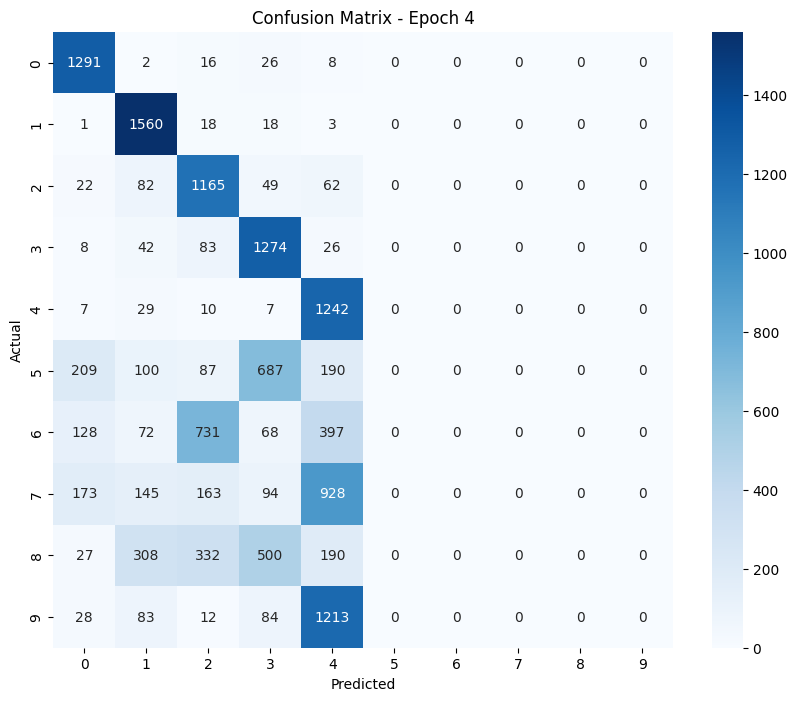

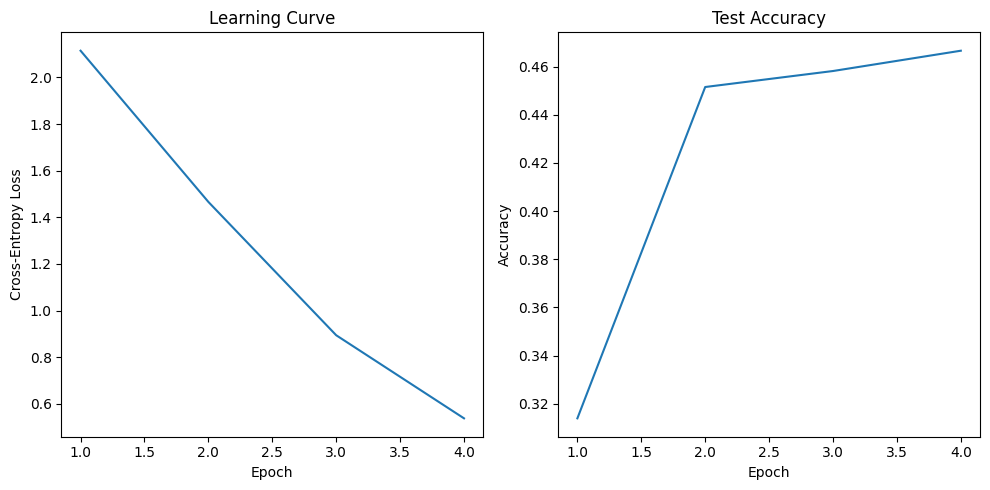

Epoch 5/15, Batch 0, Loss: 0.4553
Epoch 5/15, Batch 10, Loss: 0.4311
Epoch 5/15, Batch 20, Loss: 0.5679
Epoch 5/15, Batch 30, Loss: 0.5888
Epoch 5/15, Batch 40, Loss: 0.3028
Epoch 5/15, Batch 50, Loss: 0.3419
Epoch 5/15, Batch 60, Loss: 0.4228
Epoch 5/15, Batch 70, Loss: 0.2914
Epoch 5/15, Batch 80, Loss: 0.4666
Epoch 5/15, Batch 90, Loss: 0.3966
Epoch 5/15, Batch 100, Loss: 0.4474
Epoch 5/15, Batch 110, Loss: 0.4298
Epoch 5/15, Batch 120, Loss: 0.3012
Epoch 5/15, Batch 130, Loss: 0.3830
Epoch 5/15, Batch 140, Loss: 0.3991
Epoch 5/15, Batch 150, Loss: 0.4819
Epoch 5/15, Batch 160, Loss: 0.3271
Epoch 5/15, Batch 170, Loss: 0.4526
Epoch 5/15, Batch 180, Loss: 0.5036
Epoch 5/15, Batch 190, Loss: 0.4405
Epoch 5/15, Batch 200, Loss: 0.3737
Epoch 5/15, Batch 210, Loss: 0.3373
Epoch 5/15, Batch 220, Loss: 0.4314
Epoch 5/15, Batch 230, Loss: 0.4352
Epoch 5/15, Batch 240, Loss: 0.3689
Epoch 5/15, Batch 250, Loss: 0.3440
Epoch 5/15, Batch 260, Loss: 0.3727
Epoch 5/15, Batch 270, Loss: 0.3663
Epo

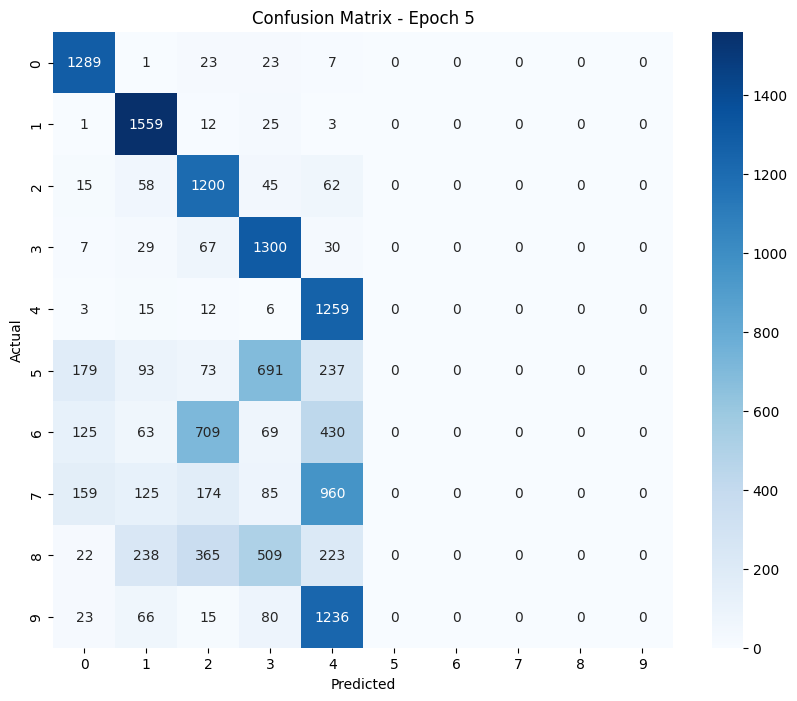

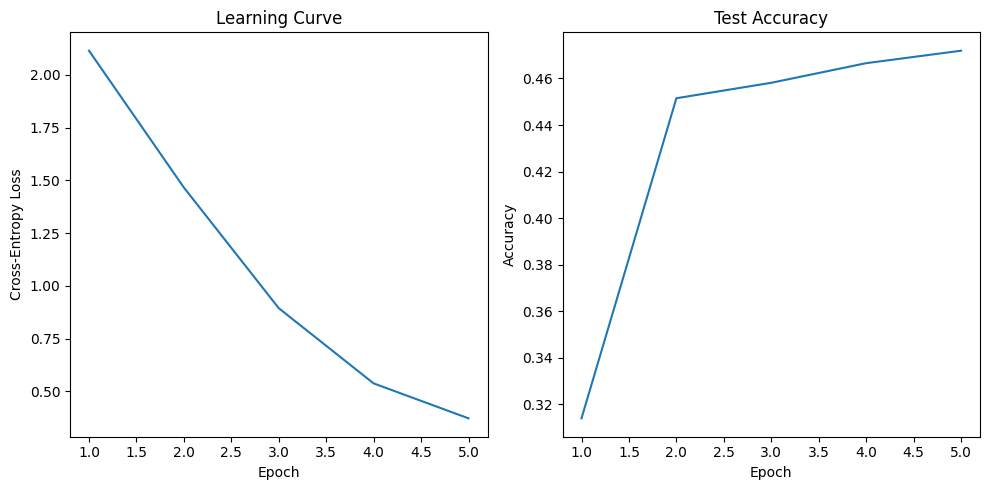

Epoch 6/15, Batch 0, Loss: 7.1335
Epoch 6/15, Batch 10, Loss: 6.7439
Epoch 6/15, Batch 20, Loss: 6.4107
Epoch 6/15, Batch 30, Loss: 5.4992
Epoch 6/15, Batch 40, Loss: 5.3793
Epoch 6/15, Batch 50, Loss: 5.1812
Epoch 6/15, Batch 60, Loss: 4.6074
Epoch 6/15, Batch 70, Loss: 4.3639
Epoch 6/15, Batch 80, Loss: 4.2620
Epoch 6/15, Batch 90, Loss: 4.0185
Epoch 6/15, Batch 100, Loss: 3.5573
Epoch 6/15, Batch 110, Loss: 3.5164
Epoch 6/15, Batch 120, Loss: 3.2192
Epoch 6/15, Batch 130, Loss: 2.9510
Epoch 6/15, Batch 140, Loss: 2.8743
Epoch 6/15, Batch 150, Loss: 2.9934
Epoch 6/15, Batch 160, Loss: 2.5941
Epoch 6/15, Batch 170, Loss: 2.3754
Epoch 6/15, Batch 180, Loss: 2.4391
Epoch 6/15, Batch 190, Loss: 2.3038
Epoch 6/15, Batch 200, Loss: 2.1533
Epoch 6/15, Batch 210, Loss: 2.0585
Epoch 6/15, Batch 220, Loss: 1.9744
Epoch 6/15, Batch 230, Loss: 1.9461
Epoch 6/15, Batch 240, Loss: 1.8829
Epoch 6/15, Batch 250, Loss: 1.8186
Epoch 6/15, Batch 260, Loss: 1.7908
Epoch 6/15, Batch 270, Loss: 1.8135
Epo

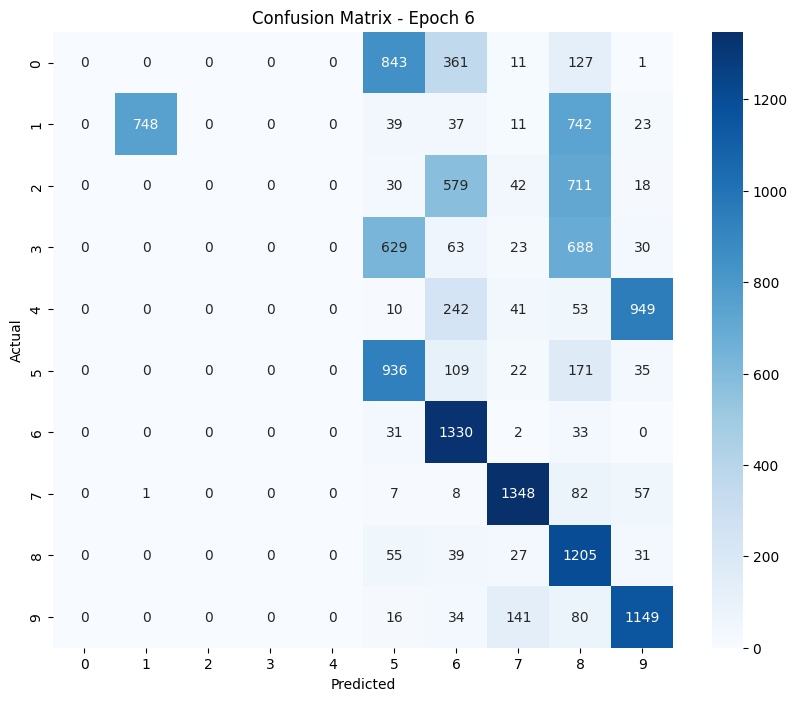

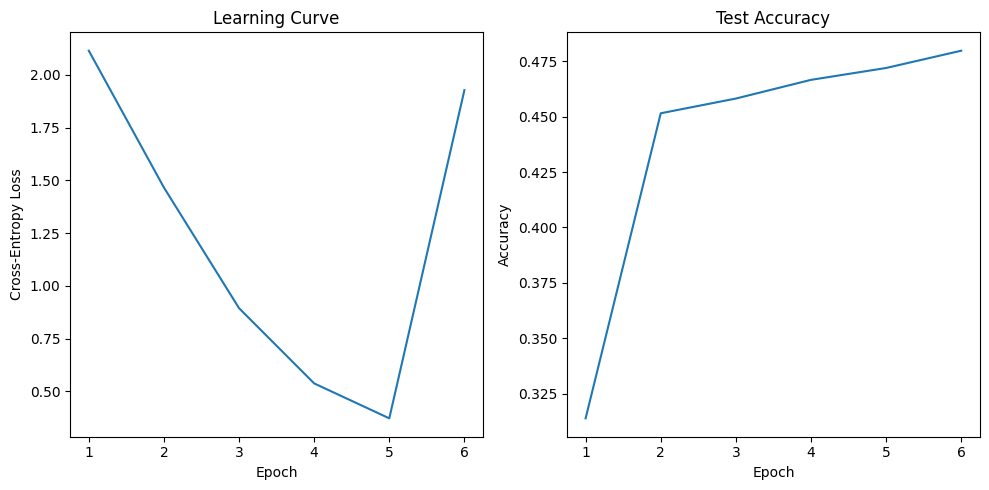

Epoch 7/15, Batch 0, Loss: 0.8716
Epoch 7/15, Batch 10, Loss: 0.9539
Epoch 7/15, Batch 20, Loss: 0.9193
Epoch 7/15, Batch 30, Loss: 0.9186
Epoch 7/15, Batch 40, Loss: 0.8695
Epoch 7/15, Batch 50, Loss: 0.9311
Epoch 7/15, Batch 60, Loss: 0.7656
Epoch 7/15, Batch 70, Loss: 0.8302
Epoch 7/15, Batch 80, Loss: 0.8273
Epoch 7/15, Batch 90, Loss: 0.9839
Epoch 7/15, Batch 100, Loss: 0.8682
Epoch 7/15, Batch 110, Loss: 1.0968
Epoch 7/15, Batch 120, Loss: 0.8466
Epoch 7/15, Batch 130, Loss: 0.7417
Epoch 7/15, Batch 140, Loss: 0.9756
Epoch 7/15, Batch 150, Loss: 0.7231
Epoch 7/15, Batch 160, Loss: 0.7349
Epoch 7/15, Batch 170, Loss: 0.6148
Epoch 7/15, Batch 180, Loss: 0.7762
Epoch 7/15, Batch 190, Loss: 0.8339
Epoch 7/15, Batch 200, Loss: 0.8036
Epoch 7/15, Batch 210, Loss: 0.8467
Epoch 7/15, Batch 220, Loss: 0.7487
Epoch 7/15, Batch 230, Loss: 0.7794
Epoch 7/15, Batch 240, Loss: 0.7374
Epoch 7/15, Batch 250, Loss: 0.7708
Epoch 7/15, Batch 260, Loss: 0.6320
Epoch 7/15, Batch 270, Loss: 0.7776
Epo

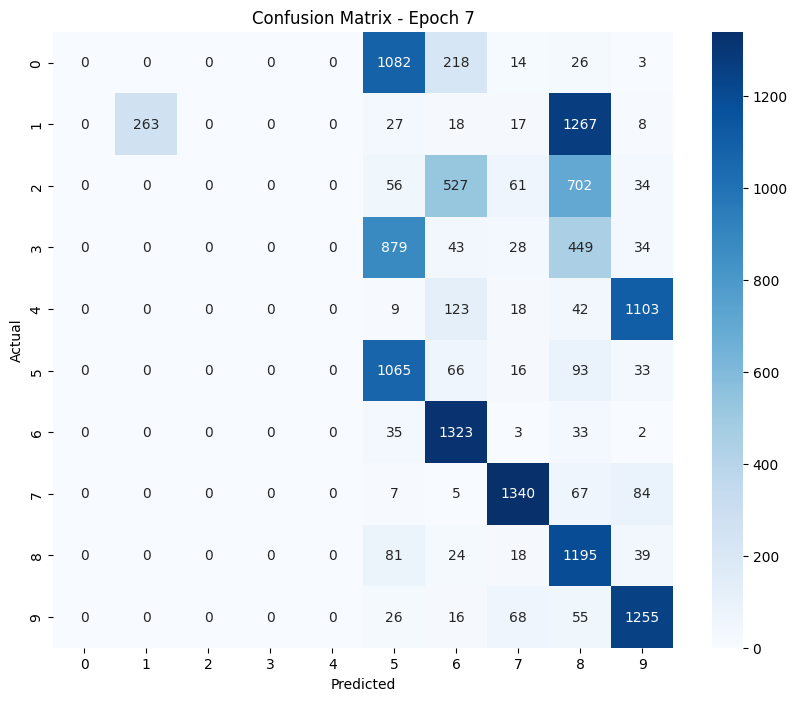

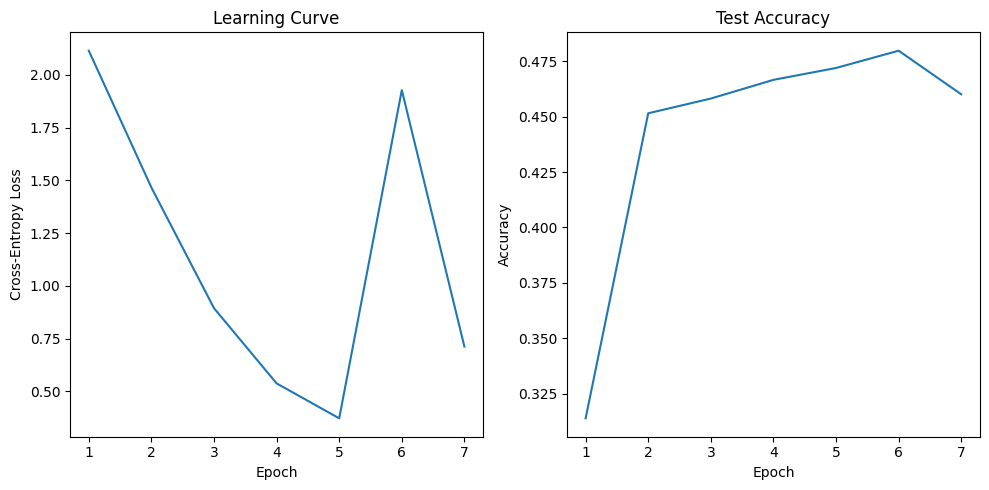

Epoch 8/15, Batch 0, Loss: 0.5196
Epoch 8/15, Batch 10, Loss: 0.6416
Epoch 8/15, Batch 20, Loss: 0.6027
Epoch 8/15, Batch 30, Loss: 0.6548
Epoch 8/15, Batch 40, Loss: 0.5297
Epoch 8/15, Batch 50, Loss: 0.6453
Epoch 8/15, Batch 60, Loss: 0.4736
Epoch 8/15, Batch 70, Loss: 0.4699
Epoch 8/15, Batch 80, Loss: 0.5565
Epoch 8/15, Batch 90, Loss: 0.6545
Epoch 8/15, Batch 100, Loss: 0.5508
Epoch 8/15, Batch 110, Loss: 0.9073
Epoch 8/15, Batch 120, Loss: 0.5931
Epoch 8/15, Batch 130, Loss: 0.4361
Epoch 8/15, Batch 140, Loss: 0.7321
Epoch 8/15, Batch 150, Loss: 0.4204
Epoch 8/15, Batch 160, Loss: 0.4733
Epoch 8/15, Batch 170, Loss: 0.3586
Epoch 8/15, Batch 180, Loss: 0.5182
Epoch 8/15, Batch 190, Loss: 0.5623
Epoch 8/15, Batch 200, Loss: 0.5585
Epoch 8/15, Batch 210, Loss: 0.6248
Epoch 8/15, Batch 220, Loss: 0.4802
Epoch 8/15, Batch 230, Loss: 0.5240
Epoch 8/15, Batch 240, Loss: 0.4892
Epoch 8/15, Batch 250, Loss: 0.5398
Epoch 8/15, Batch 260, Loss: 0.4024
Epoch 8/15, Batch 270, Loss: 0.5888
Epo

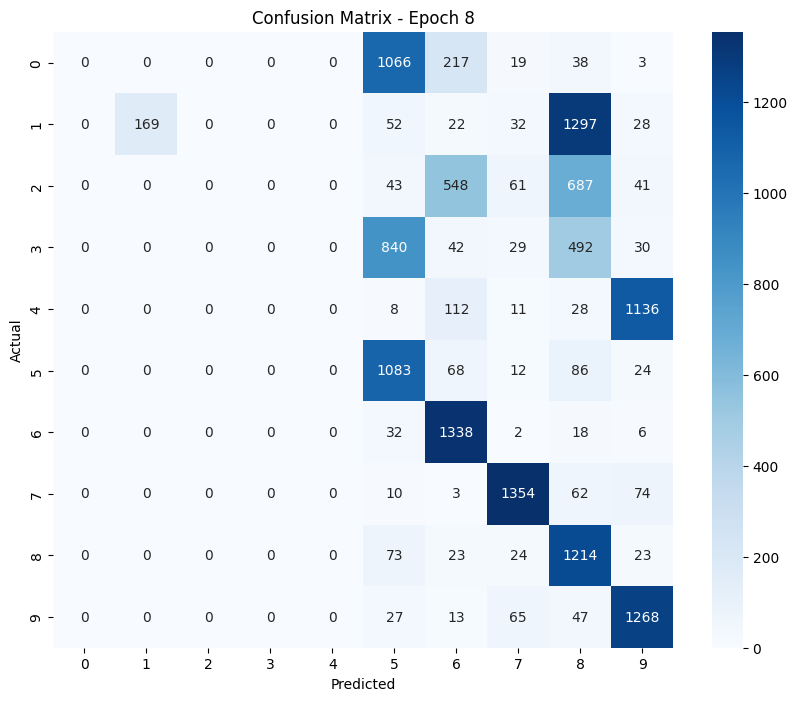

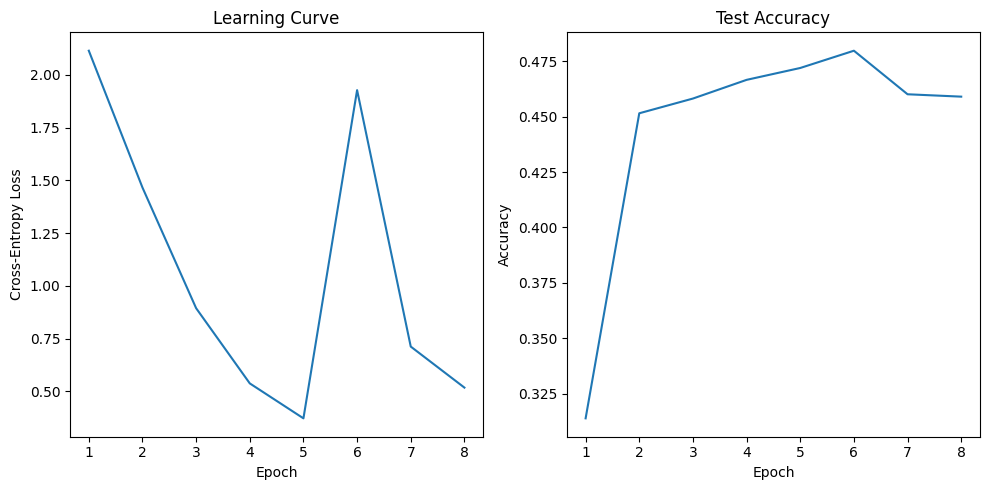

Epoch 9/15, Batch 0, Loss: 0.3983
Epoch 9/15, Batch 10, Loss: 0.5565
Epoch 9/15, Batch 20, Loss: 0.4893
Epoch 9/15, Batch 30, Loss: 0.5534
Epoch 9/15, Batch 40, Loss: 0.4157
Epoch 9/15, Batch 50, Loss: 0.5437
Epoch 9/15, Batch 60, Loss: 0.3443
Epoch 9/15, Batch 70, Loss: 0.3450
Epoch 9/15, Batch 80, Loss: 0.4788
Epoch 9/15, Batch 90, Loss: 0.5487
Epoch 9/15, Batch 100, Loss: 0.4475
Epoch 9/15, Batch 110, Loss: 0.8650
Epoch 9/15, Batch 120, Loss: 0.4962
Epoch 9/15, Batch 130, Loss: 0.3202
Epoch 9/15, Batch 140, Loss: 0.6154
Epoch 9/15, Batch 150, Loss: 0.3239
Epoch 9/15, Batch 160, Loss: 0.3799
Epoch 9/15, Batch 170, Loss: 0.2677
Epoch 9/15, Batch 180, Loss: 0.4089
Epoch 9/15, Batch 190, Loss: 0.4312
Epoch 9/15, Batch 200, Loss: 0.4636
Epoch 9/15, Batch 210, Loss: 0.5499
Epoch 9/15, Batch 220, Loss: 0.3933
Epoch 9/15, Batch 230, Loss: 0.4329
Epoch 9/15, Batch 240, Loss: 0.3863
Epoch 9/15, Batch 250, Loss: 0.4170
Epoch 9/15, Batch 260, Loss: 0.3040
Epoch 9/15, Batch 270, Loss: 0.4772
Epo

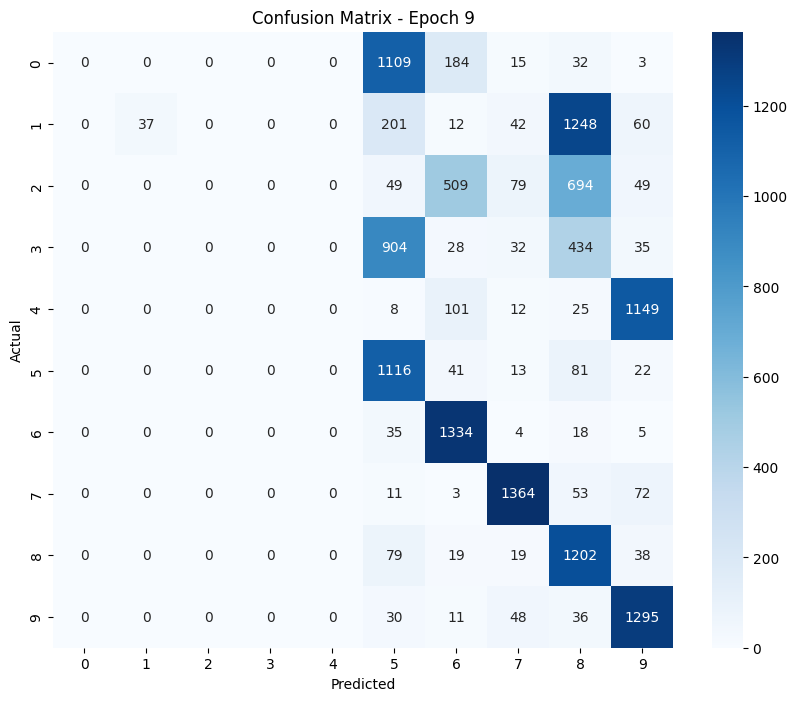

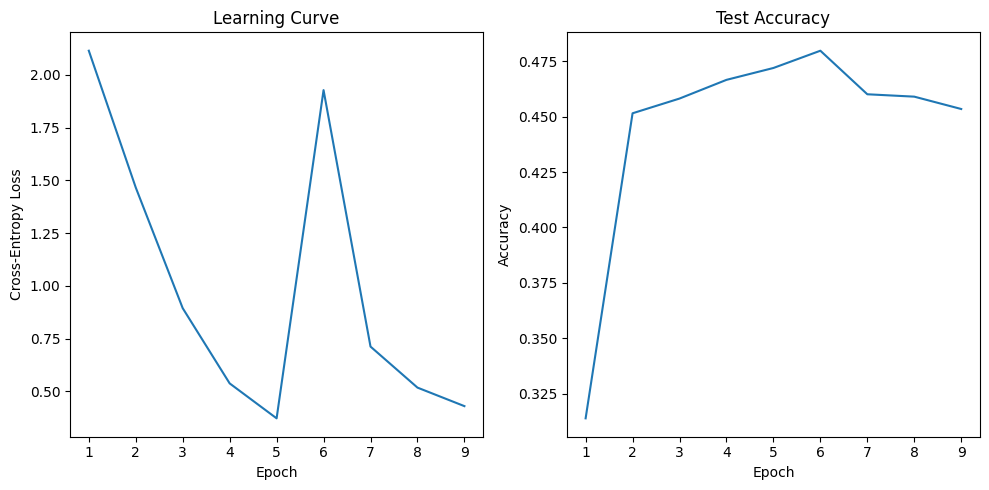

Epoch 10/15, Batch 0, Loss: 0.3252
Epoch 10/15, Batch 10, Loss: 0.5138
Epoch 10/15, Batch 20, Loss: 0.3996
Epoch 10/15, Batch 30, Loss: 0.5045
Epoch 10/15, Batch 40, Loss: 0.3476
Epoch 10/15, Batch 50, Loss: 0.4714
Epoch 10/15, Batch 60, Loss: 0.2582
Epoch 10/15, Batch 70, Loss: 0.2700
Epoch 10/15, Batch 80, Loss: 0.4132
Epoch 10/15, Batch 90, Loss: 0.4729
Epoch 10/15, Batch 100, Loss: 0.3629
Epoch 10/15, Batch 110, Loss: 0.8157
Epoch 10/15, Batch 120, Loss: 0.4504
Epoch 10/15, Batch 130, Loss: 0.2618
Epoch 10/15, Batch 140, Loss: 0.5596
Epoch 10/15, Batch 150, Loss: 0.2582
Epoch 10/15, Batch 160, Loss: 0.3160
Epoch 10/15, Batch 170, Loss: 0.2083
Epoch 10/15, Batch 180, Loss: 0.3426
Epoch 10/15, Batch 190, Loss: 0.3547
Epoch 10/15, Batch 200, Loss: 0.3895
Epoch 10/15, Batch 210, Loss: 0.5043
Epoch 10/15, Batch 220, Loss: 0.3288
Epoch 10/15, Batch 230, Loss: 0.3770
Epoch 10/15, Batch 240, Loss: 0.3109
Epoch 10/15, Batch 250, Loss: 0.3549
Epoch 10/15, Batch 260, Loss: 0.2511
Epoch 10/15,

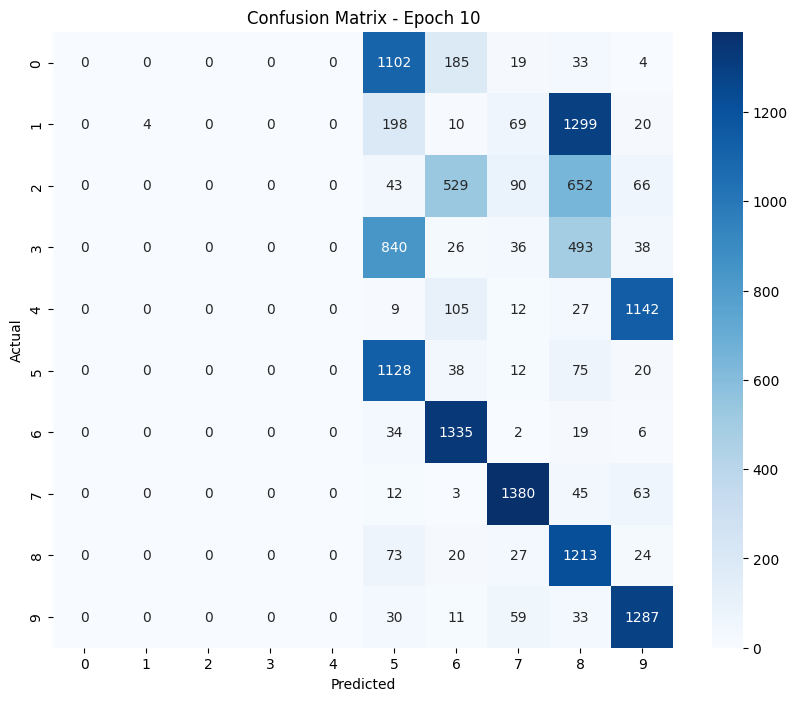

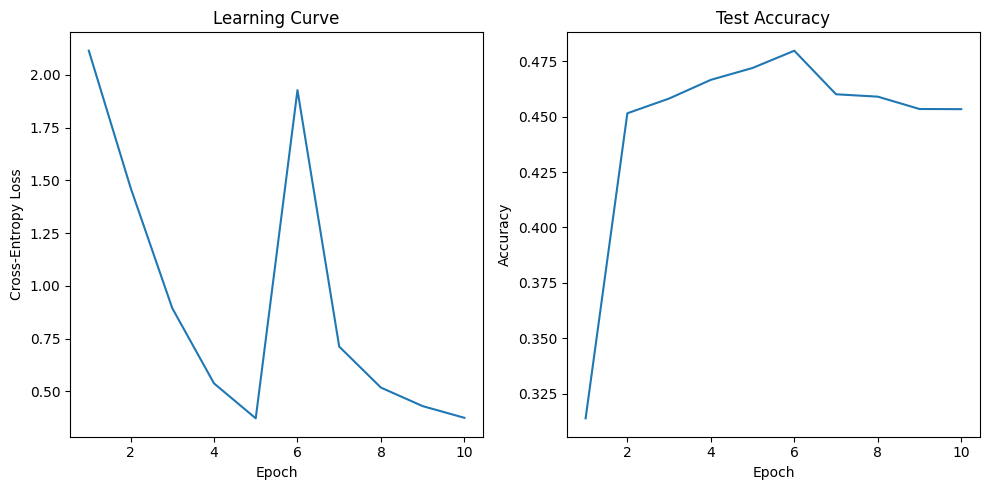

Epoch 11/15, Batch 0, Loss: 2.4259
Epoch 11/15, Batch 10, Loss: 2.6234
Epoch 11/15, Batch 20, Loss: 3.0696
Epoch 11/15, Batch 30, Loss: 2.0254
Epoch 11/15, Batch 40, Loss: 3.3992
Epoch 11/15, Batch 50, Loss: 2.4050
Epoch 11/15, Batch 60, Loss: 2.1082
Epoch 11/15, Batch 70, Loss: 1.9034
Epoch 11/15, Batch 80, Loss: 2.1667
Epoch 11/15, Batch 90, Loss: 1.9811
Epoch 11/15, Batch 100, Loss: 1.7520
Epoch 11/15, Batch 110, Loss: 1.8503
Epoch 11/15, Batch 120, Loss: 1.1979
Epoch 11/15, Batch 130, Loss: 1.0384
Epoch 11/15, Batch 140, Loss: 1.2776
Epoch 11/15, Batch 150, Loss: 1.4147
Epoch 11/15, Batch 160, Loss: 1.2341
Epoch 11/15, Batch 170, Loss: 1.3143
Epoch 11/15, Batch 180, Loss: 1.2068
Epoch 11/15, Batch 190, Loss: 0.6468
Epoch 11/15, Batch 200, Loss: 1.1934
Epoch 11/15, Batch 210, Loss: 0.8586
Epoch 11/15, Batch 220, Loss: 0.9289
Epoch 11/15, Batch 230, Loss: 1.0901
Epoch 11/15, Batch 240, Loss: 0.8782
Epoch 11/15, Batch 250, Loss: 0.9422
Epoch 11/15, Batch 260, Loss: 0.8360
Epoch 11/15,

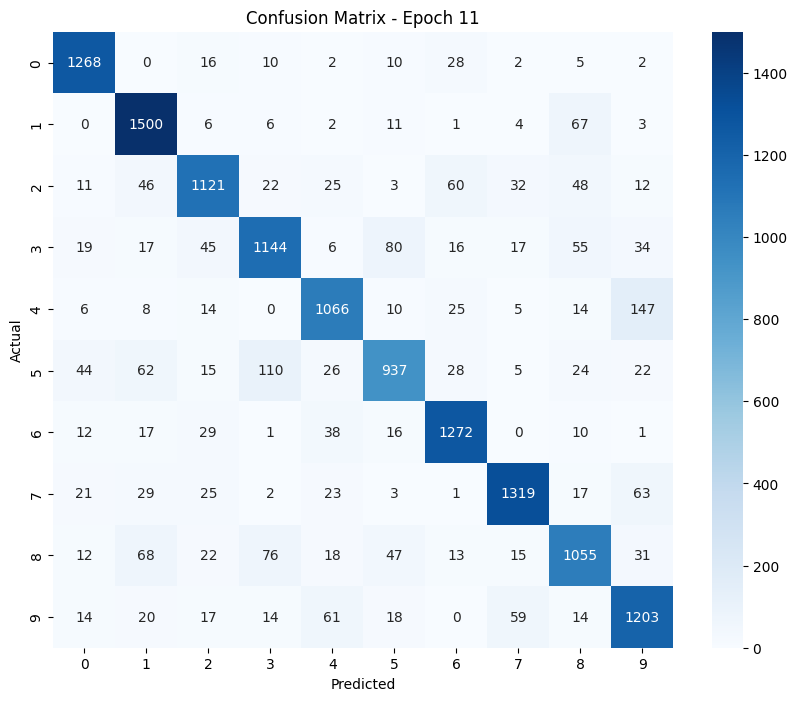

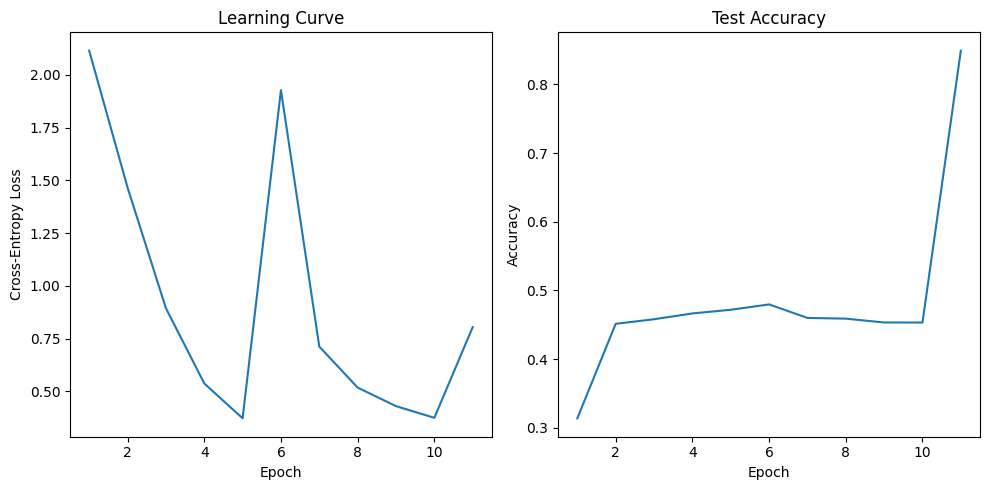

Epoch 12/15, Batch 0, Loss: 0.5460
Epoch 12/15, Batch 10, Loss: 0.6006
Epoch 12/15, Batch 20, Loss: 0.6400
Epoch 12/15, Batch 30, Loss: 0.5620
Epoch 12/15, Batch 40, Loss: 0.9093
Epoch 12/15, Batch 50, Loss: 0.5887
Epoch 12/15, Batch 60, Loss: 0.7247
Epoch 12/15, Batch 70, Loss: 0.4548
Epoch 12/15, Batch 80, Loss: 0.4810
Epoch 12/15, Batch 90, Loss: 0.6576
Epoch 12/15, Batch 100, Loss: 0.5731
Epoch 12/15, Batch 110, Loss: 0.5906
Epoch 12/15, Batch 120, Loss: 0.9249
Epoch 12/15, Batch 130, Loss: 0.4462
Epoch 12/15, Batch 140, Loss: 0.5476
Epoch 12/15, Batch 150, Loss: 0.6269
Epoch 12/15, Batch 160, Loss: 0.5935
Epoch 12/15, Batch 170, Loss: 0.7418
Epoch 12/15, Batch 180, Loss: 0.7927
Epoch 12/15, Batch 190, Loss: 0.3479
Epoch 12/15, Batch 200, Loss: 0.8395
Epoch 12/15, Batch 210, Loss: 0.7136
Epoch 12/15, Batch 220, Loss: 0.5973
Epoch 12/15, Batch 230, Loss: 0.7649
Epoch 12/15, Batch 240, Loss: 0.5842
Epoch 12/15, Batch 250, Loss: 0.6505
Epoch 12/15, Batch 260, Loss: 0.7088
Epoch 12/15,

In [ ]:
#Weight Perturbation in Non stationary learning environment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

class WeightPerturbMLP:
    def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
        self.W_h = np.random.normal(0, sigma, (input_size, hidden_size))
        self.W_y = np.random.normal(0, sigma, (hidden_size, output_size))
        self.sigma = sigma

    def forward(self, X):
        self.h = np.maximum(0, X @ self.W_h)  # ReLU activation
        self.y = self.h @ self.W_y
        return self.y

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def loss(self, X, targets):
        outputs = self.softmax(self.forward(X))
        return -np.mean(np.sum(targets * np.log(outputs + 1e-10), axis=1))

    def weight_perturbation(self, X, targets, eta, K):
        base_loss = self.loss(X, targets)

        W_h_update = np.zeros_like(self.W_h)
        W_y_update = np.zeros_like(self.W_y)

        for _ in range(K):
            Psi_h = np.random.normal(0, self.sigma, self.W_h.shape)
            Psi_y = np.random.normal(0, self.sigma, self.W_y.shape)

            W_h_perturbed = self.W_h + Psi_h
            W_y_perturbed = self.W_y + Psi_y

            self.W_h, self.W_y = W_h_perturbed, W_y_perturbed
            perturbed_loss = self.loss(X, targets)
            self.W_h, self.W_y = W_h_perturbed - Psi_h, W_y_perturbed - Psi_y

            delta_loss = perturbed_loss - base_loss

            W_h_update += (delta_loss * Psi_h) / (self.sigma**2)
            W_y_update += (delta_loss * Psi_y) / (self.sigma**2)

        W_h_update *= -eta / K
        W_y_update *= -eta / K

        return W_h_update, W_y_update

# Load and preprocess MNIST data
print("Loading MNIST data...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

# Initialize model
model = WeightPerturbMLP(784, 500, 10, sigma=0.01)

# Training parameters
epochs = 15
batch_size = 32
eta = 0.001  # Reduced learning rate
K = 10  # number of perturbation samples

# Training loop
losses = []
test_accuracies = []

print("Starting non-stationary learning...")
for epoch in range(epochs):
    epoch_losses = []

    # Determine active classes for this epoch
    if epoch < 5:
        active_classes = range(5)  # First 5 epochs: train on digits 0-4
    elif epoch < 10:
        active_classes = range(5, 10)  # Next 5 epochs: train on digits 5-9
    else:
        active_classes = range(10)  # Last 5 epochs: train on all digits

    # Filter training data for active classes
    mask = np.isin(y_train, active_classes)
    X_train_active = X_train[mask]
    y_train_active = y_train[mask]
    y_train_active_onehot = y_train_onehot[mask]

    for i in range(0, len(X_train_active), batch_size):
        batch_X = X_train_active[i:i+batch_size]
        batch_y = y_train_active_onehot[i:i+batch_size]

        W_h_update, W_y_update = model.weight_perturbation(batch_X, batch_y, eta, K)

        model.W_h += W_h_update
        model.W_y += W_y_update

        batch_loss = model.loss(batch_X, batch_y)
        epoch_losses.append(batch_loss)

        if i % (10 * batch_size) == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {batch_loss:.4f}")

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)

    # Evaluate on test set
    y_pred = model.softmax(model.forward(X_test))
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Plot confusion matrix after each epoch
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot learning curve after each epoch
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+2), losses)
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+2), test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

print("Non-stationary learning completed. Generating final visualizations...")

# Final Confusion Matrix
y_pred = model.softmax(model.forward(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Final Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("All done!")

OOD Generalisation: FA


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# from scipy.ndimage import rotate, zoom
# import cv2

# class FeedbackAlignmentMLP:
#     def __init__(self, input_size, hidden_size, output_size, sigma=0.01):
#         self.W = np.random.normal(0, sigma, (input_size, hidden_size))
#         self.W_out = np.random.normal(0, sigma, (hidden_size, output_size))
#         self.B = np.random.normal(0, sigma, (output_size, hidden_size))

#     def forward(self, X):
#         self.h = np.maximum(0, X @ self.W)
#         self.y_hat = self.h @ self.W_out
#         return self.y_hat

#     def loss(self, X, targets):
#         y_hat = self.forward(X)
#         return 0.5 * np.mean(np.sum((targets - y_hat) ** 2, axis=1))

#     def feedback_alignment_update(self, X, targets, eta):
#         y_hat = self.forward(X)
#         e = targets - y_hat
#         delta = e @ self.B
#         dW = eta * (X.T @ (delta * (self.h > 0)))
#         dW_out = eta * (self.h.T @ e)
#         return dW, dW_out

# def apply_transforms(X, transform_type):
#     X_transformed = X.copy().reshape(-1, 28, 28)

#     if transform_type == 'rotate':
#         X_transformed = np.array([rotate(img, np.random.uniform(-30, 30), reshape=False) for img in X_transformed])
#     elif transform_type == 'scale':
#         X_transformed = np.array([zoom(img, np.random.uniform(0.8, 1.2), order=1) for img in X_transformed])
#     elif transform_type == 'translate':
#         X_transformed = np.array([np.roll(img, shift=(np.random.randint(-3, 4), np.random.randint(-3, 4)), axis=(0, 1)) for img in X_transformed])
#     elif transform_type == 'noise':
#         X_transformed += np.random.normal(0, 0.1, X_transformed.shape)
#     elif transform_type == 'contrast':
#         X_transformed = np.array([cv2.addWeighted(img, np.random.uniform(0.5, 1.5), img, 0, 0) for img in X_transformed])

#     return X_transformed.reshape(-1, 784)

# # Load MNIST data for training
# print("Loading MNIST data...")
# X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# X_mnist = X_mnist / 255.0
# y_mnist = y_mnist.astype(int)

# # Load EMNIST data for testing
# print("Loading EMNIST data...")
# X_emnist, y_emnist = fetch_openml('emnist_letters', version=1, return_X_y=True, as_frame=False)
# X_emnist = X_emnist / 255.0
# y_emnist = y_emnist.astype(int) - 1  # Adjust labels to start from 0

# # Use only digits from EMNIST (first 10 classes)
# mask = y_emnist < 10
# X_emnist = X_emnist[mask]
# y_emnist = y_emnist[mask]

# # Split MNIST data
# X_train, _, y_train, _ = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)
# y_train_onehot = np.eye(10)[y_train]

# # Prepare EMNIST test data
# X_test, y_test = X_emnist, y_emnist
# y_test_onehot = np.eye(10)[y_test]

# # Initialize model
# model = FeedbackAlignmentMLP(784, 500, 10, sigma=0.01)

# # Training parameters
# epochs = 10
# batch_size = 128
# eta = 0.001

# # Training loop
# losses = []
# test_accuracies = []

# print("Starting training...")
# for epoch in range(epochs):
#     epoch_losses = []
#     for i in range(0, len(X_train), batch_size):
#         batch_X = X_train[i:i+batch_size]
#         batch_y = y_train_onehot[i:i+batch_size]

#         dW, dW_out = model.feedback_alignment_update(batch_X, batch_y, eta)

#         model.W += dW
#         model.W_out += dW_out

#         batch_loss = model.loss(batch_X, batch_y)
#         epoch_losses.append(batch_loss)

#         if i % (10 * batch_size) == 0:
#             print(f"Epoch {epoch+1}/{epochs}, Batch {i//batch_size}, Loss: {batch_loss:.4f}")

#     epoch_loss = np.mean(epoch_losses)
#     losses.append(epoch_loss)

#     # Evaluate on test set with different transforms
#     transform_types = ['original', 'rotate', 'scale', 'translate', 'noise', 'contrast']
#     test_accuracies_epoch = []

#     for transform in transform_types:
#         X_test_transformed = apply_transforms(X_test, transform) if transform != 'original' else X_test
#         y_pred = model.forward(X_test_transformed)
#         accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
#         test_accuracies_epoch.append(accuracy)
#         print(f"Epoch {epoch+1}/{epochs}, {transform.capitalize()} Transform Accuracy: {accuracy:.4f}")

#     test_accuracies.append(test_accuracies_epoch)

#     print(f"Epoch {epoch+1}/{epochs} completed. Avg Loss: {epoch_loss:.4f}")

# # Plot learning curve and test accuracies
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, epochs+1), losses)
# plt.title('Learning Curve')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')

# plt.subplot(1, 2, 2)
# for i, transform in enumerate(transform_types):
#     plt.plot(range(1, epochs+1), [acc[i] for acc in test_accuracies], label=transform)
# plt.title('Test Accuracy on EMNIST with Transforms')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

# print("Training completed. Generating final visualizations...")

# # Final Confusion Matrix (using original EMNIST data)
# y_pred = model.forward(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# cm = confusion_matrix(y_test, y_pred_classes)

# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix on EMNIST Test Set')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# print("All done!")

Loading MNIST data...


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Loading EMNIST data...


OpenMLError: Dataset emnist_letters with version 1 not found.